In [5]:
import pandas as pd
import glob
import numpy as np
import seaborn as sb
import subprocess
import os
%matplotlib inline

### TADs directory

In [93]:
tad_dic = {}
tad_key_dic = {}
tad_df_sorted = pd.read_csv('/home/shared/Data/encode/mouse/TAD_positions_mm10_sorted.bed',sep='\t',header=None)
for indx,r in enumerate(tad_df_sorted.iterrows()):
    pos = "{}:{}-{}".format(r[1][0],r[1][1],r[1][2])
    tad_dic[pos] = "TAD_{}".format(indx)
    tad_key_dic["TAD_{}".format(indx)] = pos
    

In [9]:
for i in tad_dic.keys():
    subprocess.call('mkdir /home/shared/Data/encode/mouse/heart/{}'.format(tad_dic[i]),shell=True)

##### Enh for each tads

In [11]:
enh_tads = pd.read_csv('/home/shared/Data/encode/mouse/enh_within_TAD.bed',sep='\t',header=None)

In [17]:
enh_tads_dic = {}
for r in enh_tads.iterrows():
    tad_pos = "{}:{}-{}".format(r[1][3],r[1][4],r[1][5])
    enh_pos = (r[1][0],r[1][1],r[1][2])
    tad_key = tad_dic[tad_pos]
    if tad_key not in enh_tads_dic.keys():
        enh_tads_dic[tad_key] = [enh_pos]
    else:
        enh_tads_dic[tad_key].append(enh_pos)
    

In [20]:
for k in enh_tads_dic.keys():
    enh_df = pd.DataFrame(enh_tads_dic[k])
    enh_df.to_csv('/home/shared/Data/encode/mouse/heart/{}/enh.bed'.format(k),sep='\t',index=None,header=None)
        

##### Gene for each tads

In [22]:
gene_tads = pd.read_csv('/home/shared/Data/encode/mouse/pc_within_TAD.bed',sep='\t',header=None)

In [24]:
gene_tads_dic = {}
for r in gene_tads.iterrows():
    tad_pos = "{}:{}-{}".format(r[1][6],r[1][7],r[1][8])
    gene_pos = (r[1][0],r[1][1],r[1][2],r[1][3],r[1][4],r[1][5])
    tad_key = tad_dic[tad_pos]
    if tad_key not in gene_tads_dic.keys():
        gene_tads_dic[tad_key] = [gene_pos]
    else:
        gene_tads_dic[tad_key].append(gene_pos)

In [27]:
for k in gene_tads_dic.keys():
    gene_df = pd.DataFrame(gene_tads_dic[k])
    gene_df.to_csv('/home/shared/Data/encode/mouse/heart/{}/gene.bed'.format(k),sep='\t',index=None,header=None)
    

### Calculate enh-gene distance for each TAD

In [34]:
tad_dirs = glob.glob('/home/shared/Data/encode/mouse/heart/TAD_*')

In [455]:

def get_distance_df(gene_df,enh_df):
    enh_pos = []
    for r in enh_df.iterrows():
        pos = "{}:{}-{}".format(r[1][0],r[1][1],r[1][2])
        enh_pos.append(pos)
    gene_names = list(gene_df[3])
    out_d = pd.DataFrame(0,index=enh_pos,columns=gene_names)
    for g in gene_df.iterrows():
        name = g[1][3]
        if g[1][5] == '-':
            g_start = g[1][2]
        else:
            g_start = g[1][1]
        for e in enh_df.iterrows():
            e_pos = "{}:{}-{}".format(e[1][0],e[1][1],e[1][2])
            e_mid = e[1][1]+((e[1][2]-e[1][1])/2)
            d = np.abs(g_start - e_mid)
            out_d.ix[e_pos,name] = int(d)
    return out_d

def get_distance_based_weight(distance):
    ##set weight 0 for distance greater than 500 kb
    distance[distance > 500000] = 1e10000
    dist_weight = 1/np.log2(distance)
    if set(dist_weight.values.flatten()) == {0}:
        wmin = np.sort(list(set(dist_weight.values.flatten())))[0]
        wmax = np.sort(list(set(dist_weight.values.flatten())))[0]
        scaled_dist_weight = dist_weight
    else:
        wmin = np.sort(list(set(dist_weight.values.flatten())))[1]
        wmax = np.sort(list(set(dist_weight.values.flatten())))[-1]
        scaled_dist_weight = (dist_weight-wmin)/(wmax-wmin)
        scaled_dist_weight[scaled_dist_weight<0] = 0
    return(scaled_dist_weight)

In [456]:
enh_df = pd.read_csv('{}/enh.bed'.format(d),sep='\t',header=None)
gene_df = pd.read_csv('{}/gene.bed'.format(d),sep='\t',header=None)

In [457]:
enh_gene_dist = get_distance_df(gene_df,enh_df)

In [458]:
scaled_weight = get_distance_based_weight(enh_gene_dist)

In [459]:
scaled_weight

,Gm10800,Gm10801
chr2:97477948-97479667,0.0,0.0
chr2:97485015-97485999,0.0,0.0
chr2:97487146-97488369,0.0,0.0
chr2:97523964-97524877,0.0,0.0
chr2:97542663-97545012,0.0,0.0


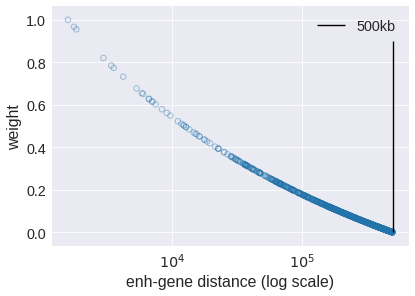

In [303]:
sb.set_context('paper',font_scale=1.8)
sb.plt.scatter(enh_gene_dist.values.flatten(),scaled_weight.values.flatten(),edgecolors='#2374AB',facecolors='none',s=30,linewidths=1,alpha=0.4)
sb.plt.xscale('log')
sb.plt.vlines(500000,0,0.9,label='500kb')
sb.plt.xlabel('enh-gene distance (log scale)')
sb.plt.ylabel('weight')
sb.plt.legend()

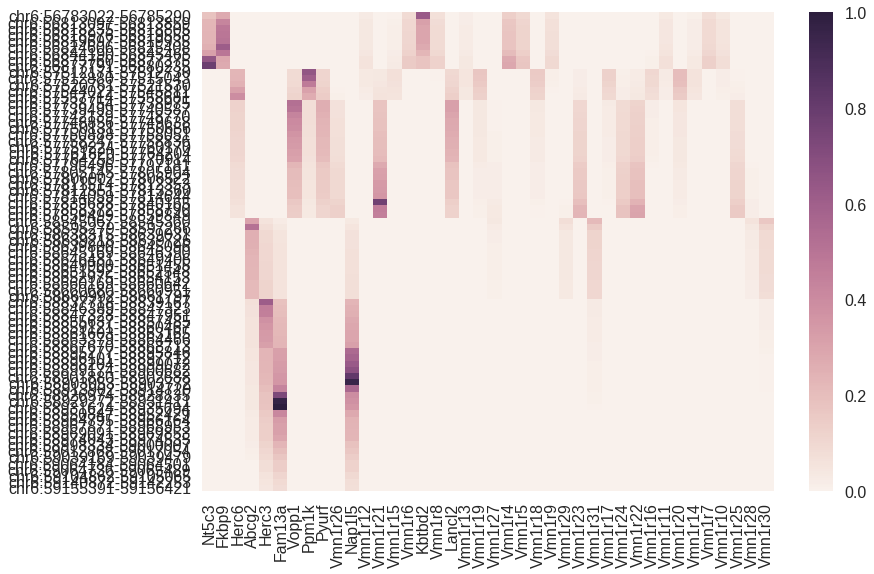

In [284]:
sb.set_context('poster')
sb.heatmap(scaled_weight)

## get enh and gene signal for each tad

##### gene signal

In [327]:
exp = pd.read_csv('/home/shared/Data/encode/mouse/gene_expression_log2TPM_signal_matrix.txt',sep='\t')
enh = pd.read_csv('/home/shared/Data/encode/mouse/enh_H3K27ac_log2TPM_signal_matrix.txt',sep='\t',index_col=0)

In [328]:
gencode_m4 = pd.read_csv('/home/shared/Data/gencode/mouse/M4/protein_coding.gtf',sep='\t',header=None)
eid_to_name = {}
for indx,r in enumerate(gencode_m4.iterrows()):
    eid = r[1][8].split('gene_id "')[-1].split('";')[0]
    name = r[1][8].split('; gene_name "')[-1].split('";')[0]
    gtype = r[1][8].split('; gene_type "')[-1].split('";')[0]
    pos = '{}:{}-{}'.format(r[1][0],r[1][3],r[1][4])
    strand = r[1][6]
    eid_to_name[eid] = [name,gtype,pos,strand,indx]

count = 0
pos_tup = []
eid_name_tup = []
tup = []
for g in exp['gene_id']:
    if g in eid_to_name.keys():
        tup.append((eid_to_name[g][0],g))
eid_gene = pd.DataFrame(tup)

In [329]:
tissue_of_interest = ['lung','kidney','stomach','intestine','embryonic-facial-prominence','neural-tube','limb','midbrain','forebrain','liver','hindbrain','heart']
time = ['P0','e11.5','e12.5','e13.5','e14.5','e15.5','e16.5']
exp.set_index('gene_id',inplace=True)
exp_ft = exp.ix[:,[any(st in c for st in tissue_of_interest) and any(t in c for t in time) for c in exp.columns]]
exp_ft.reset_index(inplace=True)
exp_pc = exp_ft.loc[[g in list(eid_gene[1]) for g in exp_ft['gene_id']],:]
exp_pc.reset_index(drop=True,inplace=True)
exp_pc['name'] = list(eid_gene[0])
del(exp_pc['gene_id'])
exp_pc_df = exp_pc.set_index('name')
exp_pc_df = exp_pc_df[~exp_pc_df.index.duplicated()]

/home/vamin/softwares/anaconda2/envs/py34/lib/python3.4/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [331]:
exp_pc_df.to_csv('/home/shared/Data/encode/mouse/gene_expression_log2TPM_signal_processed_matrix.txt',sep='\t')

##### enh signal

In [335]:
enh_pos = []
for r in enh.iterrows():
    pos = "{}:{}-{}".format(r[1][0],r[1][1],r[1][2])
    enh_pos.append(pos)

In [336]:
enh['Enhancer'] = enh_pos 

In [342]:
enh.set_index('Enhancer',inplace=True)

In [340]:
del(enh['chr'])
del(enh['start'])
del(enh['stop'])

In [344]:
enh.to_csv('/home/shared/Data/encode/mouse/enh_H3K27ac_log2TPM_signal_processed_matrix.txt',sep='\t')

#### P0 Network

In [362]:
tissue_of_interest = ['heart']
#time = ['P0','e11.5','e12.5','e13.5','e14.5','e15.5','e16.5']
time = ['P0']
heart_rna_seq_to_remove = ['ENCFF662WLV','ENCFF705YYN','unknown']

exp_ft_k = exp_pc_df.ix[:,[all(sb not in c for sb in heart_rna_seq_to_remove) and any(st in c for st in tissue_of_interest) and any(t in c for t in time) for c in exp_pc_df.columns]]

enh_ft_k = enh.ix[:,[any(st in c for st in tissue_of_interest) and any(t in c for t in time) for c in enh.columns]]

In [365]:
p0_heart_mean_gene_exp = pd.DataFrame(exp_ft_k.mean(axis=1))
p0_heart_mean_enh_k27ac = pd.DataFrame(enh_ft_k.mean(axis=1))

In [368]:
tad_gene_exp = p0_heart_mean_gene_exp.ix[scaled_weight.columns,:]

In [369]:
tad_enh_signal = p0_heart_mean_enh_k27ac.ix[scaled_weight.index,:]

In [386]:
tad_enh_signal.index == enh_gene_weight.index

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True], dtype=bool)

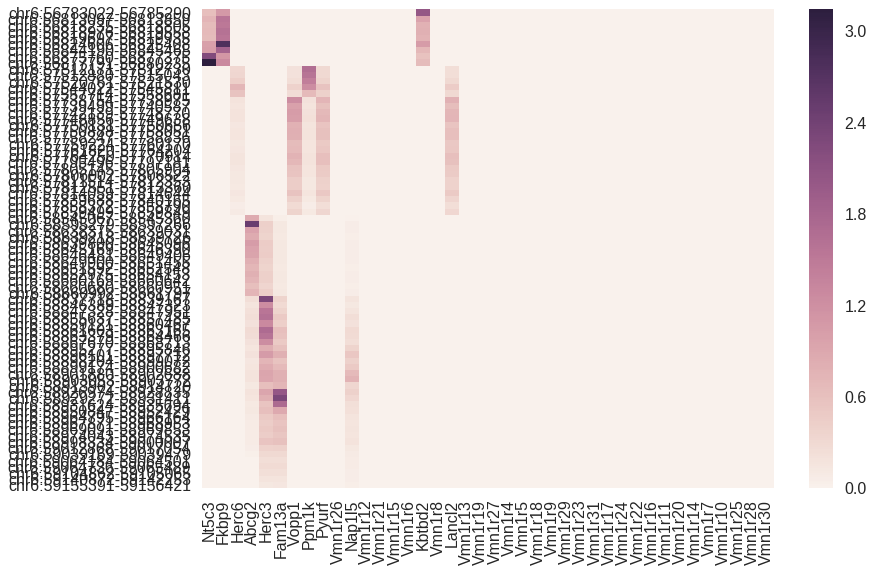

In [381]:
sb.set_context('poster')
sb.heatmap(np.multiply(scaled_weight,np.sqrt(np.matmul(tad_enh_signal,tad_gene_exp.T))))

In [ ]:
def get_enh_gene_weights(tup):
    tad_dir,context_exp,context_enh,context_info = tup
    enh_path = '{}/enh.bed'.format(tad_dir)
    gene_path = '{}/gene.bed'.format(tad_dir)
    if os.path.isfile(enh_path) and os.path.isfile(gene_path):
        enh_df = pd.read_csv(enh_path,sep='\t',header=None)
        gene_df = pd.read_csv(gene_path,sep='\t',header=None)
        enh_gene_dist = get_distance_df(gene_df,enh_df)
        scaled_weight = get_distance_based_weight(enh_gene_dist)
        #scaled_weight.to_csv('{}/enh_gene_dist_scaled_weight.txt'.format(tad_dir),sep='\t')
        tad_gene_exp = context_exp.ix[scaled_weight.columns,:]
        tad_enh_signal = context_enh.ix[scaled_weight.index,:]
        enh_gene_weight = np.multiply(scaled_weight,np.sqrt(np.matmul(tad_enh_signal,tad_gene_exp.T)))
        enh_gene_weight.to_csv('{}/{}_enh_gene_weight.txt'.format(tad_dir,context_info),sep='\t')

In [461]:
counter = {'eg': 0, 'g': 0, 'e': 0 , 'n': 0}
enh_gene_tads = []
for d in tad_dirs:
    enh_path = '{}/enh.bed'.format(d)
    gene_path = '{}/gene.bed'.format(d)
    if os.path.isfile(enh_path) and os.path.isfile(gene_path):
        counter['eg'] += 1
        enh = sum(1 for line in open(enh_path))
        gene = sum(1 for line in open(gene_path))
#         if enh <= 1:
#             print(tad_key_dic[d.split('/')[-1]])
#             next
        enh_gene_tads.append((int(enh),int(gene)))
        enh_df = pd.read_csv(enh_path,sep='\t',header=None)
        gene_df = pd.read_csv(gene_path,sep='\t',header=None)
        enh_gene_dist = get_distance_df(gene_df,enh_df)
        scaled_weight = get_distance_based_weight(enh_gene_dist)
        scaled_weight.to_csv('{}/enh_gene_dist_scaled_weight.txt'.format(d),sep='\t')
        tad_gene_exp = p0_heart_mean_gene_exp.ix[scaled_weight.columns,:]
        tad_enh_signal = p0_heart_mean_enh_k27ac.ix[scaled_weight.index,:]
        enh_gene_weight = np.multiply(scaled_weight,np.sqrt(np.matmul(tad_enh_signal,tad_gene_exp.T)))
        enh_gene_weight.to_csv('{}/heart_P0_enh_gene_weight.txt'.format(d),sep='\t')
    elif os.path.isfile(enh_path):
        counter['e'] += 1
        enh = sum(1 for line in open(enh_path))
        enh_gene_tads.append((int(enh),0))
        print(tad_key_dic[d.split('/')[-1]])
    elif os.path.isfile(gene_path):
        counter['g'] += 1
        gene = sum(1 for line in open(gene_path))
        enh_gene_tads.append((0,int(gene)))
    else:
        counter['n'] += 1
        enh_gene_tads.append((0,0))
        
    

chr13:103129920-103689920
chr8:56601203-57321203
chr7:92051490-92571490
chr9:29672415-30432415


In [84]:
enh_gene_tads_df = pd.DataFrame(enh_gene_tads)

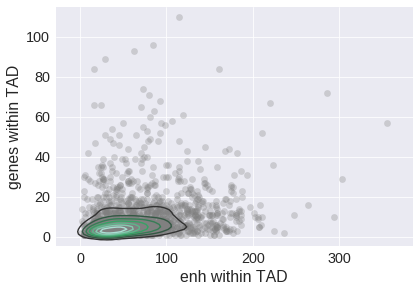

In [90]:
sb.set_context('paper',font_scale=1.8)
x = np.array(enh_gene_tads_df[0])
y = np.array(enh_gene_tads_df[1])
sb.kdeplot(x,y,nlevel=30)
sb.plt.scatter(x,y,alpha=0.3,color="grey",s=40)
sb.plt.xlabel('enh within TAD')
sb.plt.ylabel('genes within TAD')

In [106]:
counter

{'e': 4, 'eg': 1675, 'g': 0, 'n': 0}

In [481]:
tad_dirs = glob.glob('/home/shared/Data/encode/mouse/heart/TADs/TAD_*')
all_network = pd.DataFrame(0,index=all_weight.index,columns=all_weight.columns)
all_network_dict = all_network.to_dict()
for d in tad_dirs:
    enh_path = '{}/enh.bed'.format(d)
    gene_path = '{}/gene.bed'.format(d)
    weight_path = '{}/heart_P0_enh_gene_weight.txt'.format(d)
    if os.path.isfile(enh_path) and os.path.isfile(gene_path) and os.path.isfile(weight_path):
        weight = pd.read_csv(weight_path,sep='\t',index_col=0)
        weight_dict = weight.to_dict()
        for c in weight_dict.keys():
            for r in weight_dict[c].keys():
                all_network_dict[c][r] = weight_dict[c][r]


In [474]:
all_weight.fillna(0,inplace=True)

In [479]:
hdf = pd.HDFStore('/home/shared/Data/encode/mouse/heart/heart_P0_enh-gene_network.h5')
hdf['/enh_gene_all_weights'] = all_weight
hdf.close()


## Evaluate Data

In [6]:
data_analysis = {'embryonic-facial-prominence': ['e11.5', 'e15.5', 'e12.5', 'e13.5', 'e14.5'],
 'forebrain': ['e12.5', 'e11.5', 'e15.5', 'e13.5', 'e14.5', 'e16.5', 'P0'],
 'heart': ['e11.5', 'e16.5', 'e13.5', 'e15.5', 'P0', 'e12.5', 'e14.5'],
 'hindbrain': ['e14.5', 'e11.5', 'e15.5', 'e13.5', 'P0', 'e12.5', 'e16.5'],
 'intestine': ['P0', 'e15.5', 'e14.5', 'e16.5'],
 'kidney': ['e16.5', 'e14.5', 'e15.5', 'P0'],
 'limb': ['e12.5', 'e13.5', 'e15.5', 'e14.5', 'e11.5'],
 'liver': ['P0', 'e16.5', 'e11.5', 'e15.5', 'e12.5', 'e13.5', 'e14.5'],
 'lung': ['e14.5', 'P0', 'e16.5', 'e15.5'],
 'midbrain': ['e16.5', 'e13.5', 'e14.5', 'e11.5', 'e15.5', 'e12.5', 'P0'],
 'neural-tube': ['e14.5', 'e13.5', 'e11.5', 'e15.5', 'e12.5'],
 'stomach': ['e14.5', 'P0', 'e15.5', 'e16.5']}

In [7]:
rnaseq_to_remove = ['ENCFF662WLV','ENCFF705YYN','ENCFF026IQF','ENCFF892XES','ENCFF668RJN','ENCFF993NNK','ENCFF569ODO','ENCFF863BCB','ENCFF250DXJ','ENCFF434WEQ']

count = 0
for k in data_analysis.keys():
    for v in data_analysis[k]:
        count += 1
        print(count,k,v)
        plt.figure(count)
        context = exp_pc_df.ix[:,['{}_{}'.format(k,v) in c for c in exp_pc_df.columns]]
        context = context.ix[:,[all(sb not in c for sb in rnaseq_to_remove) for c in context.columns]]
        sb.heatmap(context.corr(),vmin=0,vmax=1)

1 heart e11.5


NameError: name 'plt' is not defined

1 stomach e14.5
2 stomach P0
3 stomach e15.5
4 stomach e16.5
5 limb e12.5
6 limb e13.5
7 limb e15.5
8 limb e14.5
9 limb e11.5
10 midbrain e16.5
11 midbrain e13.5
12 midbrain e14.5
13 midbrain e11.5
14 midbrain e15.5
15 midbrain e12.5
16 midbrain P0
17 intestine P0
18 intestine e15.5
19 intestine e14.5
20 intestine e16.5
21 neural-tube e14.5


/home/vamin/softwares/anaconda2/envs/py34/lib/python3.4/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


22 neural-tube e13.5
23 neural-tube e11.5
24 neural-tube e15.5
25 neural-tube e12.5
26 liver P0
27 liver e16.5
28 liver e11.5
29 liver e15.5
30 liver e12.5
31 liver e13.5
32 liver e14.5
33 heart e11.5
34 heart e16.5
35 heart e13.5
36 heart e15.5
37 heart P0
38 heart e12.5
39 heart e14.5
40 embryonic-facial-prominence e11.5
41 embryonic-facial-prominence e15.5
42 embryonic-facial-prominence e12.5
43 embryonic-facial-prominence e13.5
44 embryonic-facial-prominence e14.5
45 lung e14.5
46 lung P0
47 lung e16.5
48 lung e15.5
49 hindbrain e14.5
50 hindbrain e11.5
51 hindbrain e15.5
52 hindbrain e13.5
53 hindbrain P0
54 hindbrain e12.5
55 hindbrain e16.5
56 kidney e16.5
57 kidney e14.5
58 kidney e15.5
59 kidney P0
60 forebrain e12.5
61 forebrain e11.5
62 forebrain e15.5
63 forebrain e13.5
64 forebrain e14.5
65 forebrain e16.5
66 forebrain P0


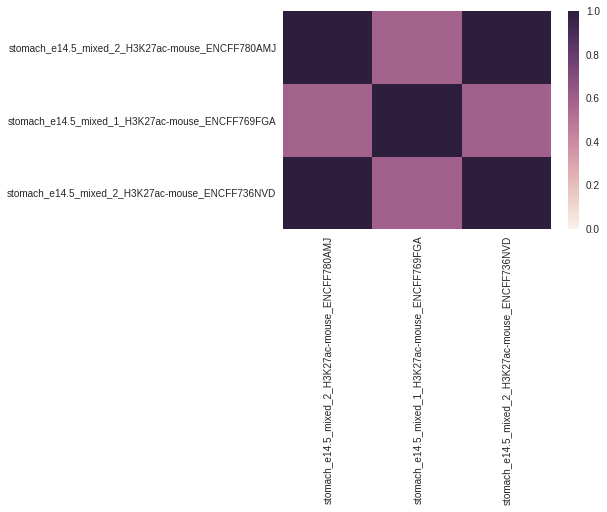

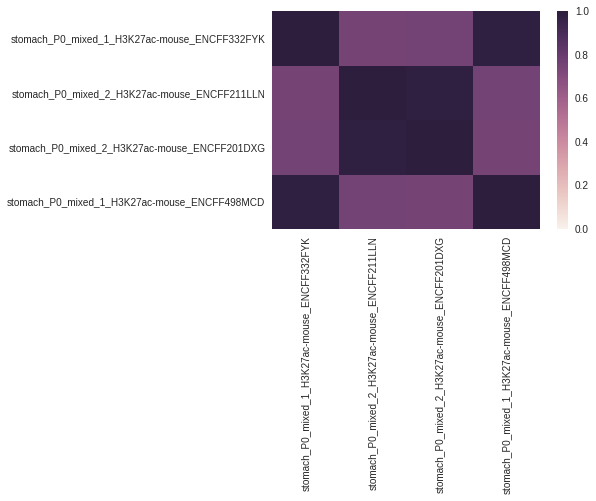

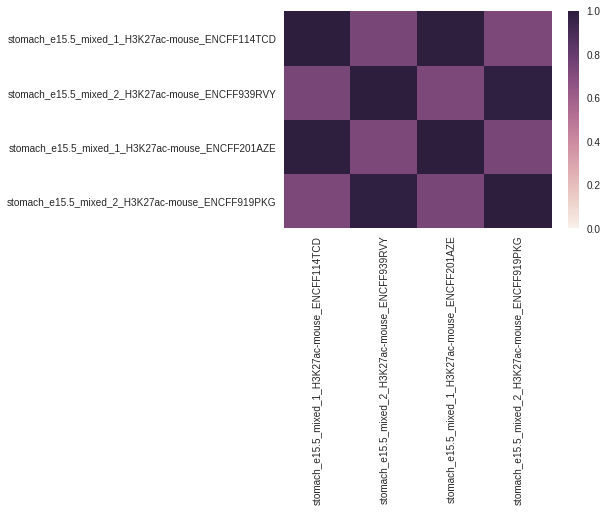

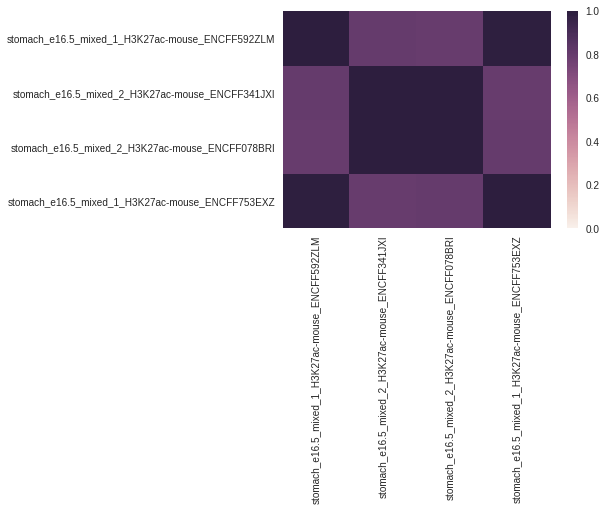

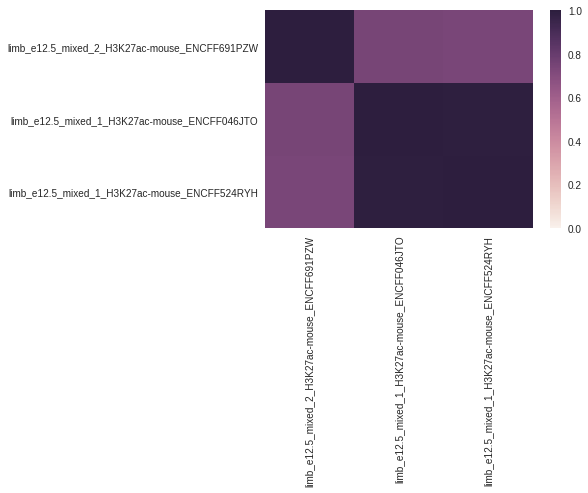

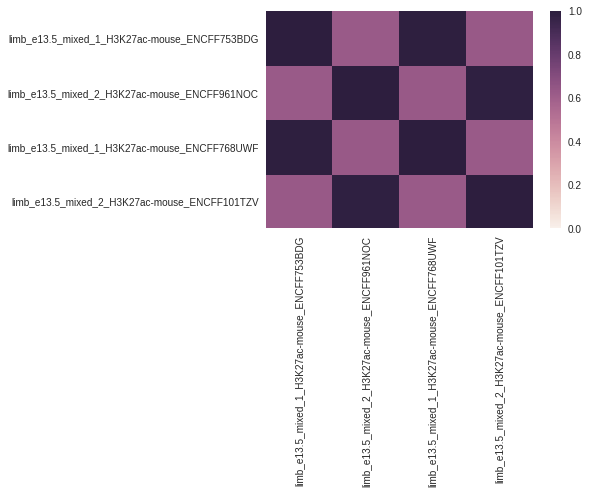

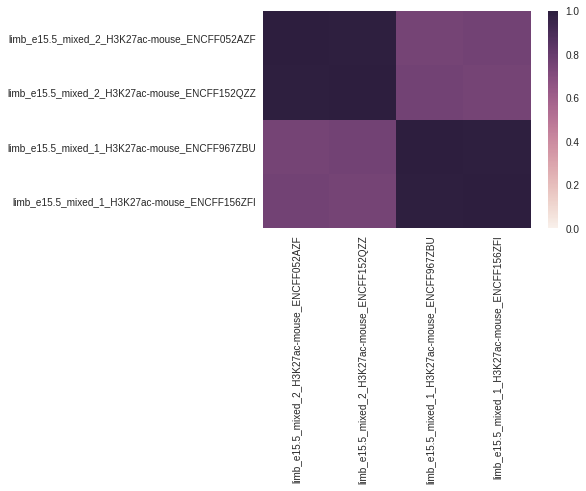

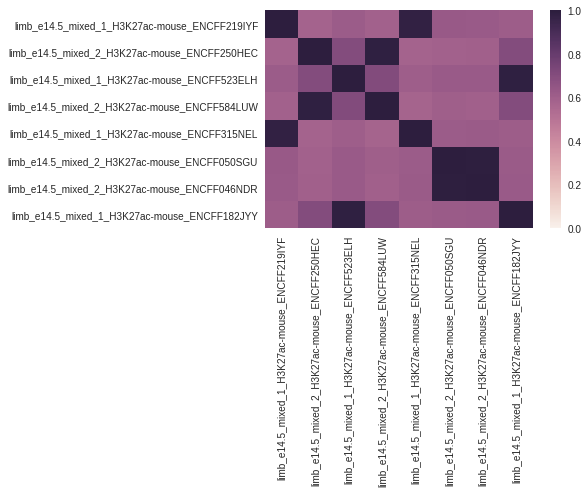

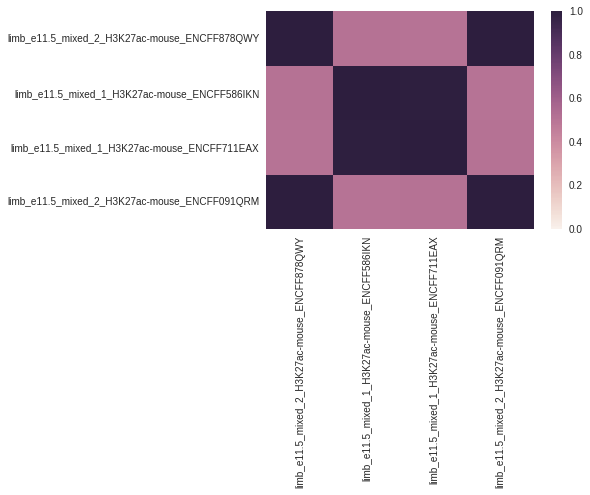

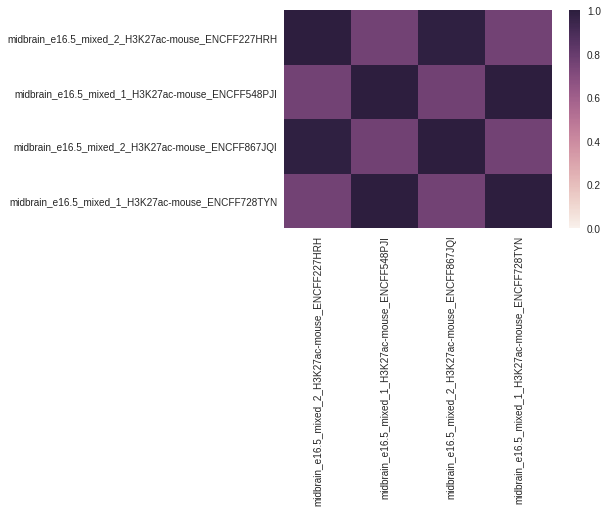

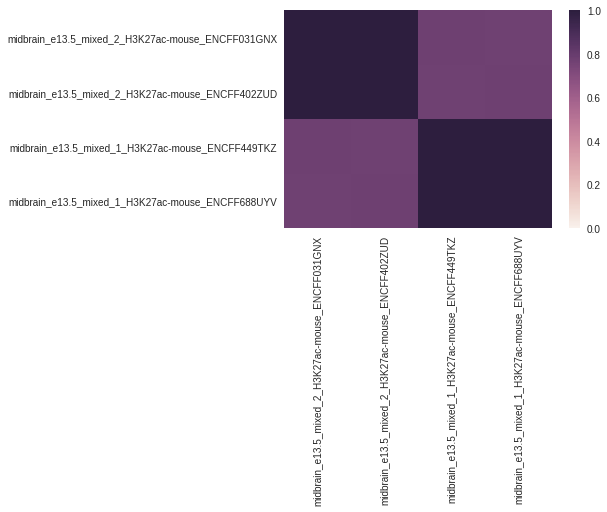

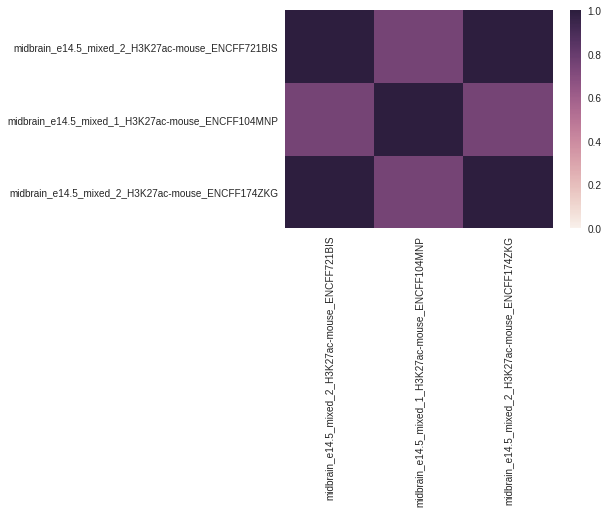

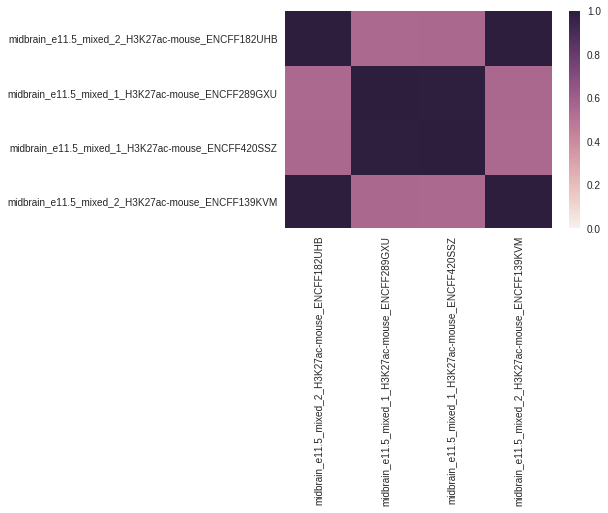

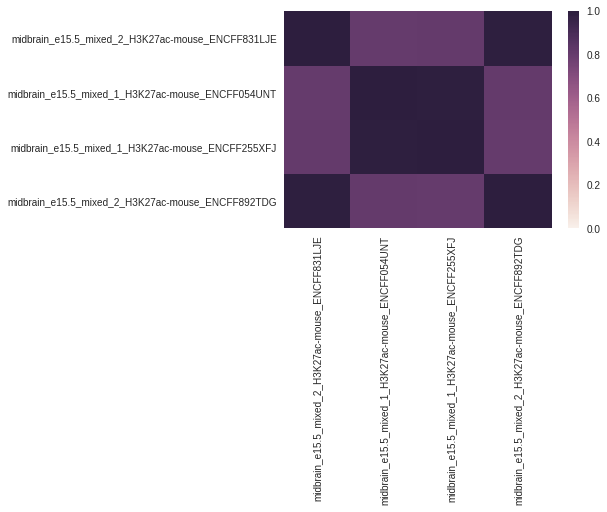

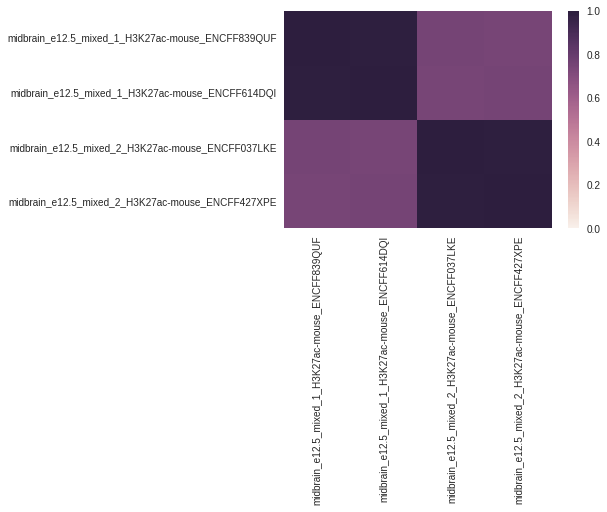

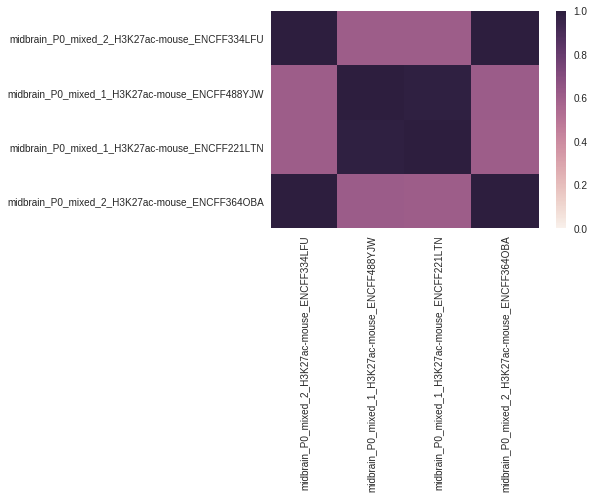

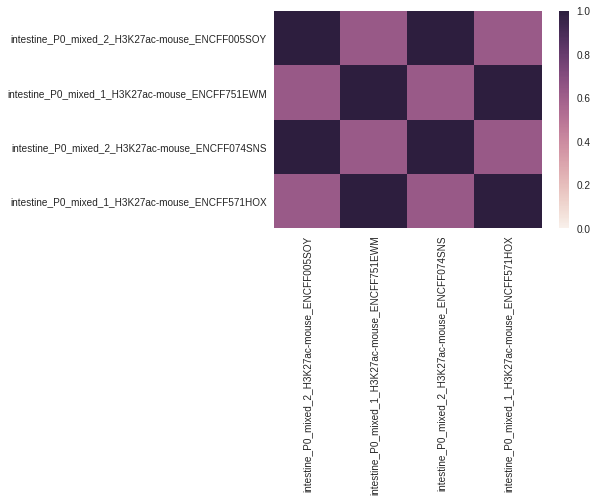

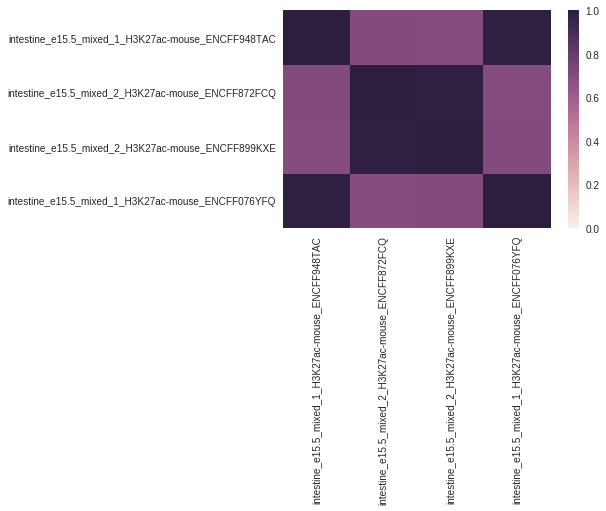

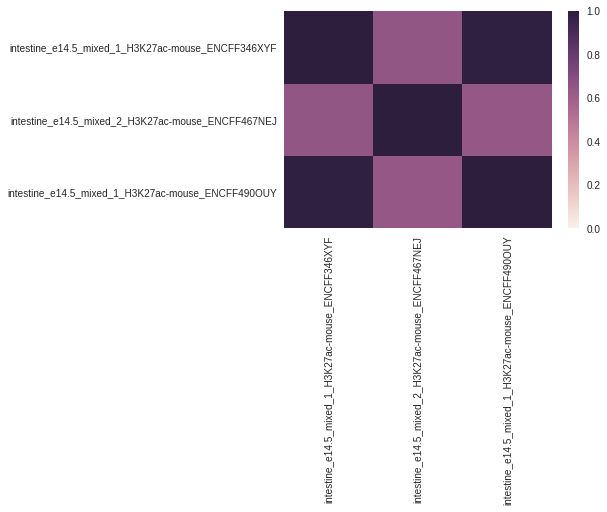

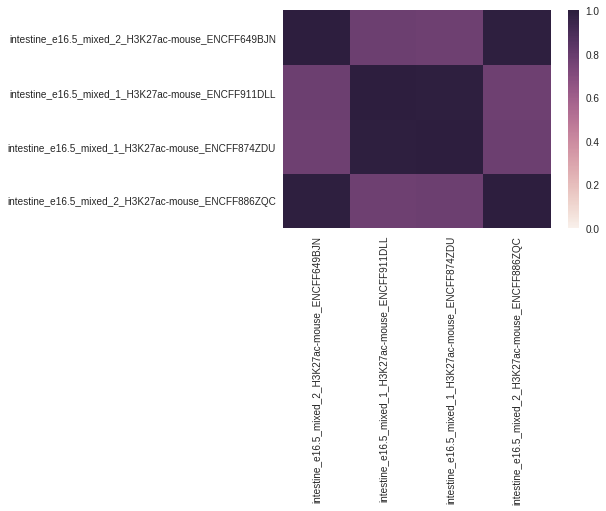

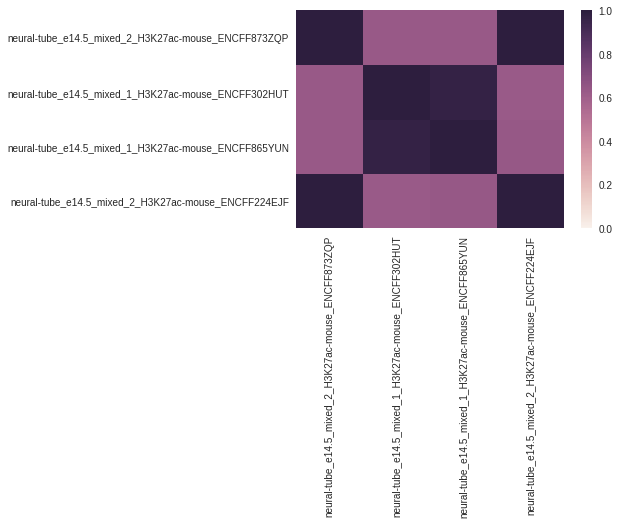

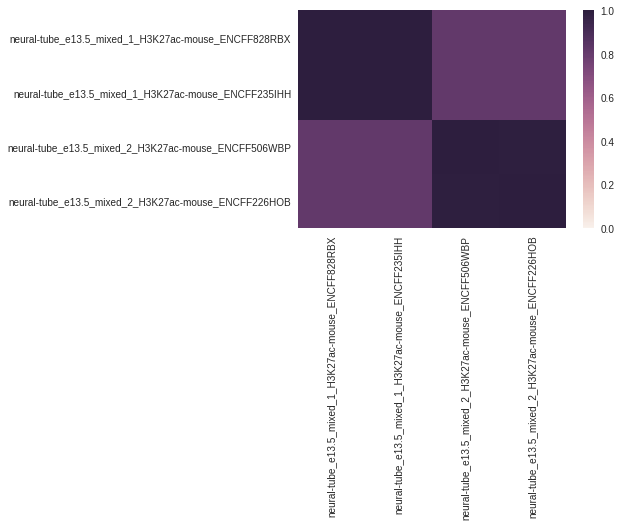

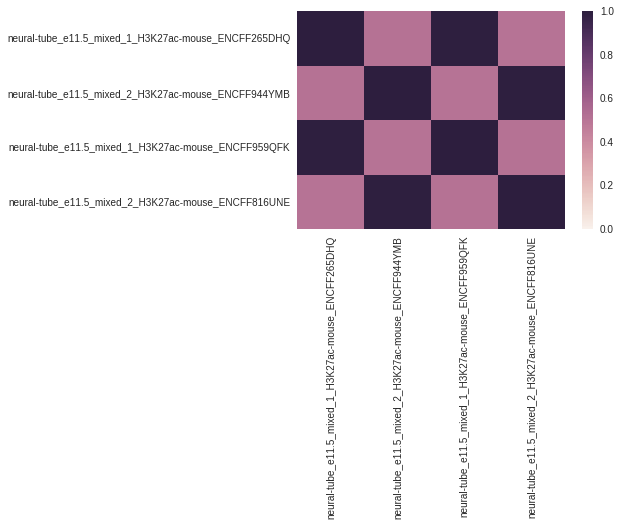

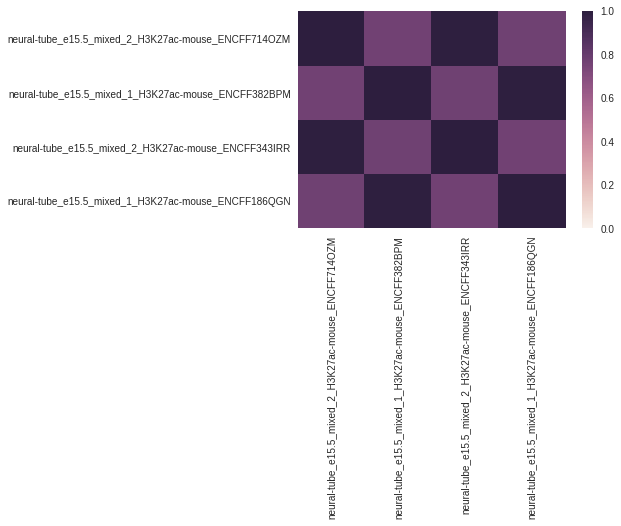

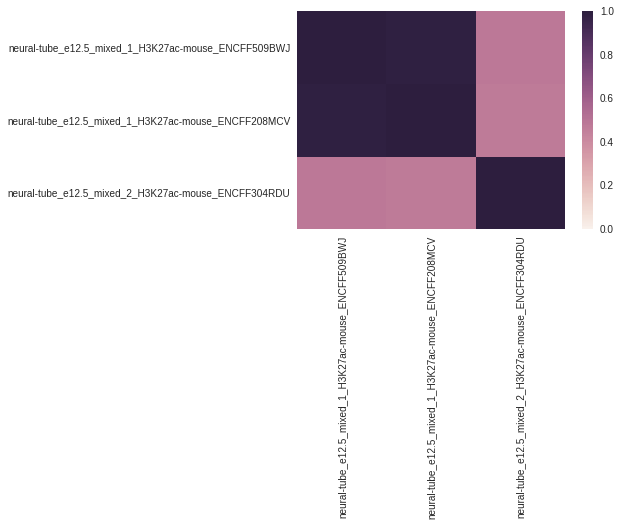

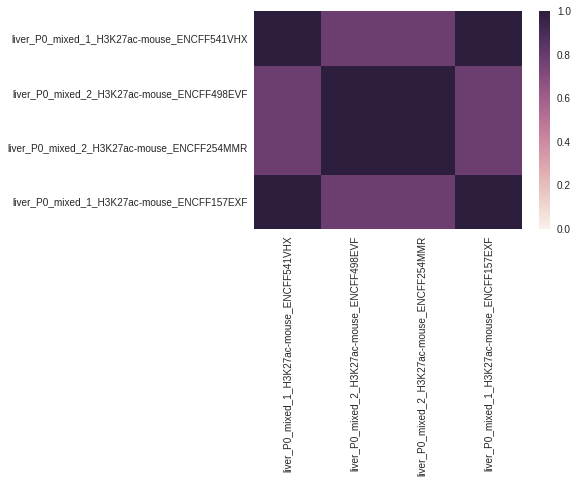

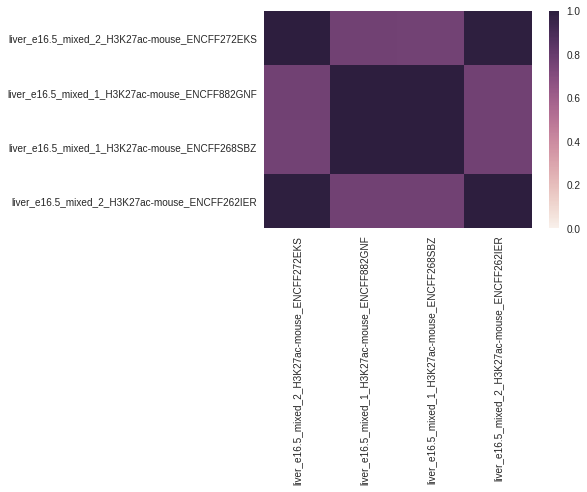

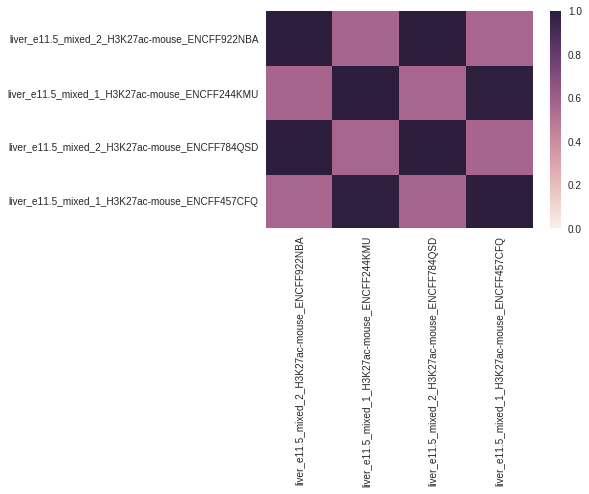

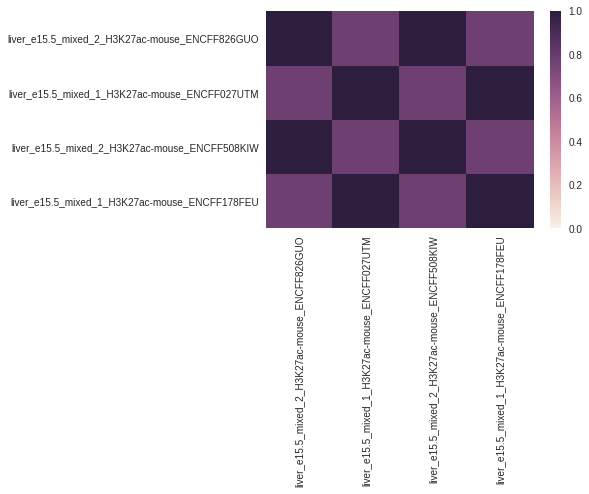

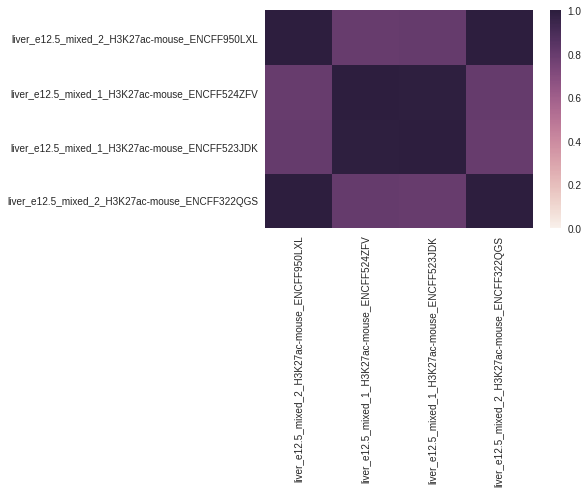

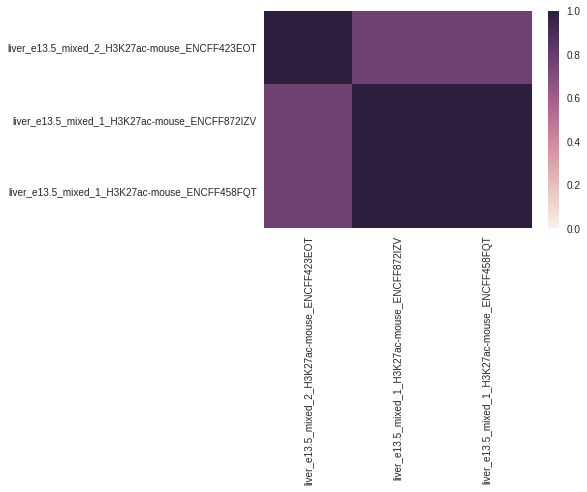

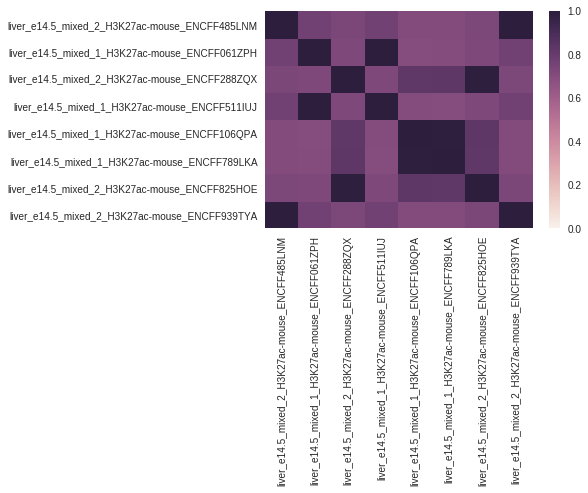

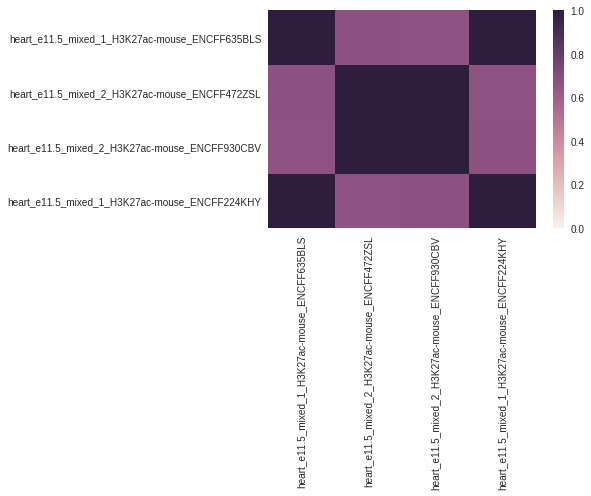

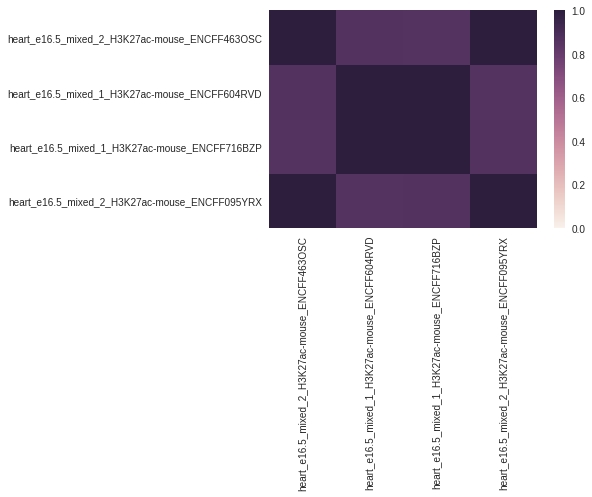

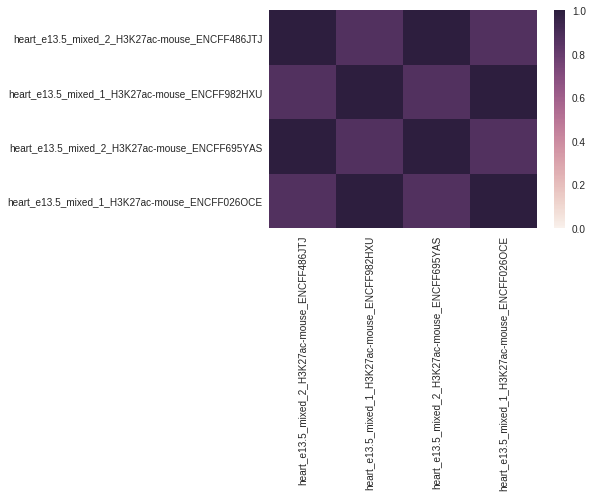

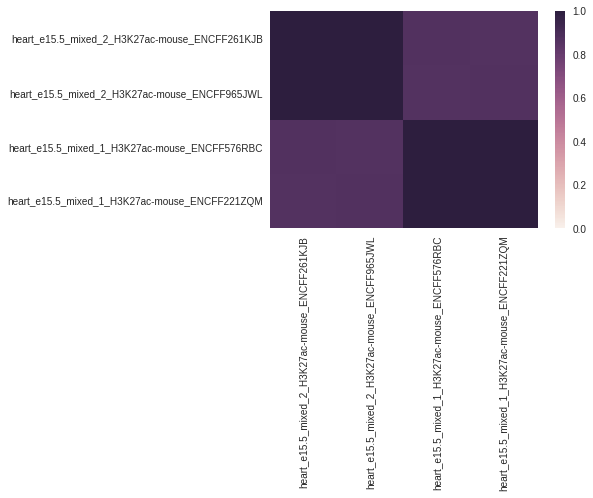

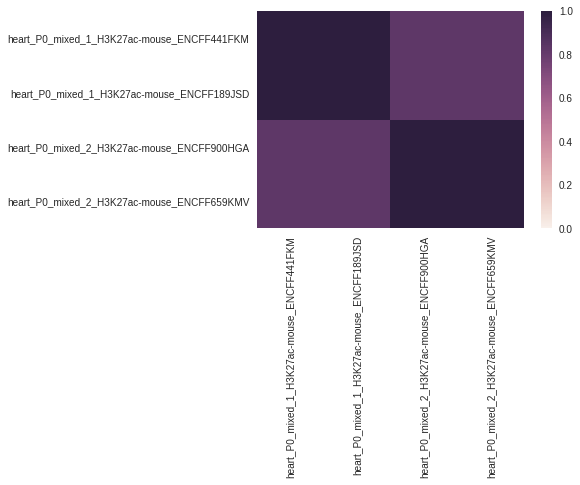

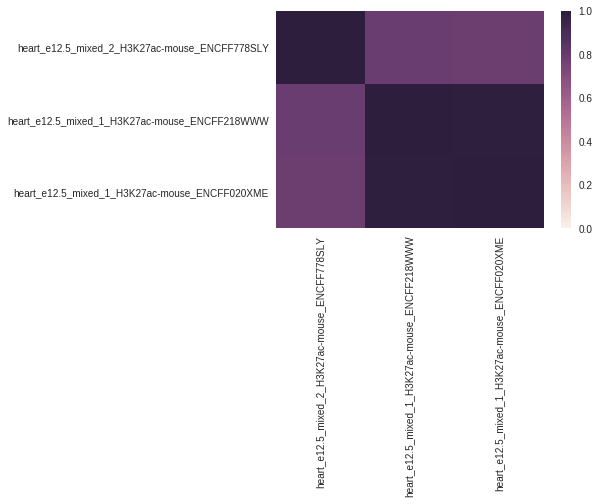

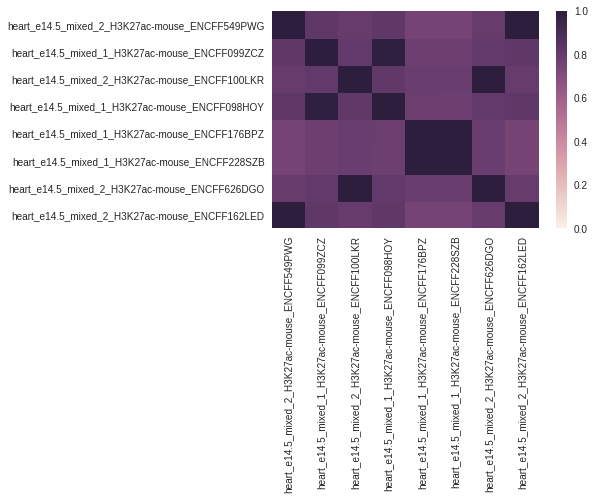

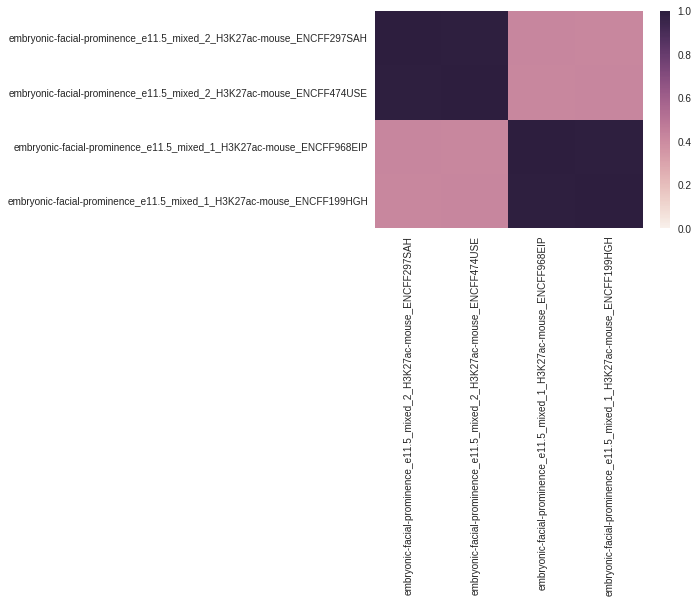

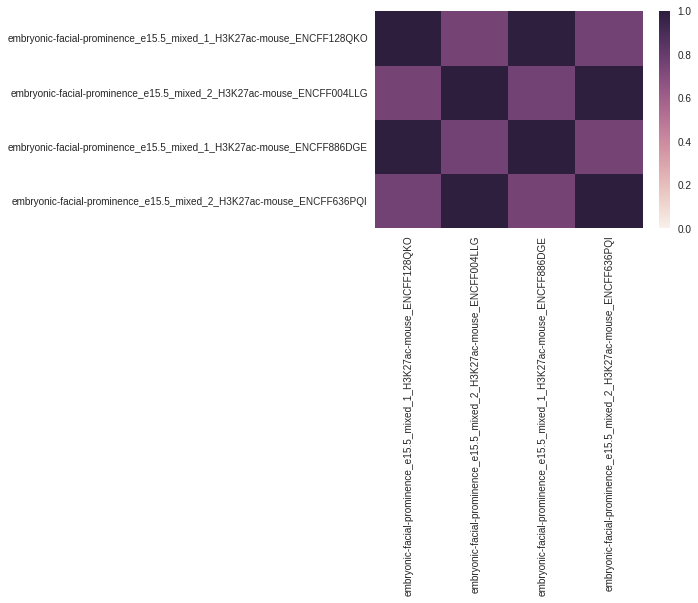

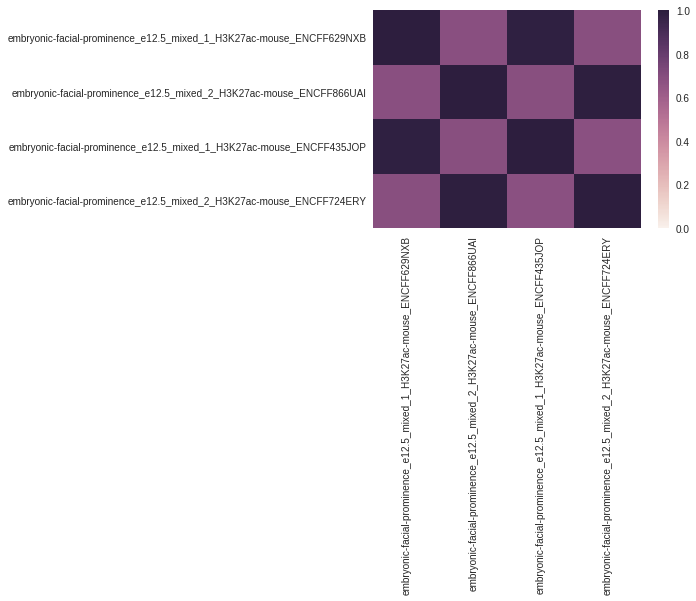

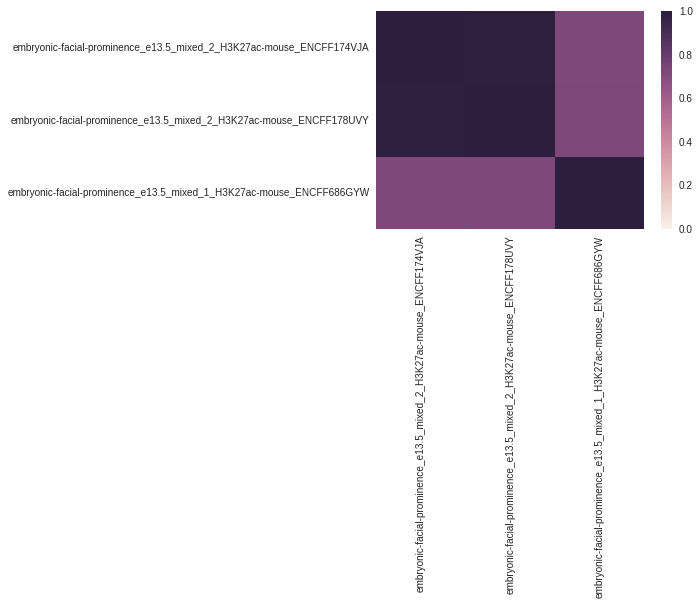

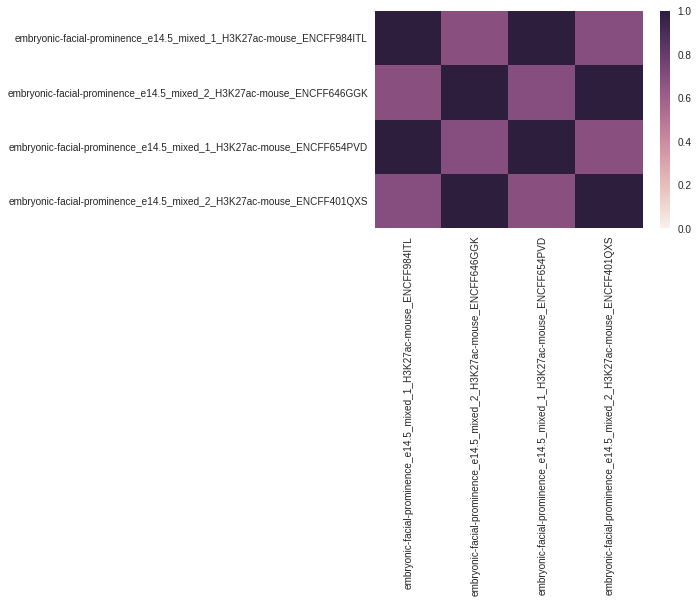

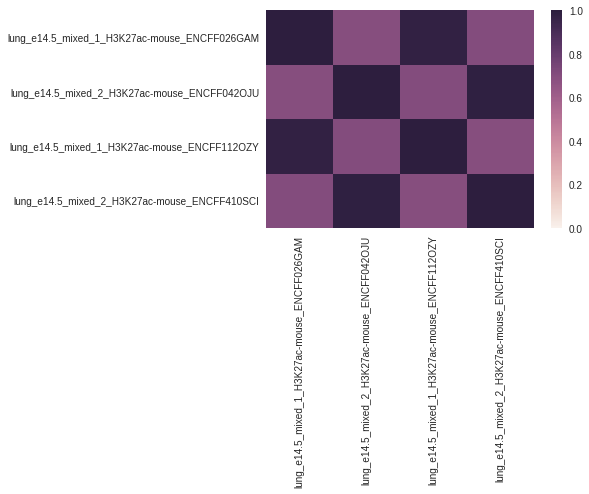

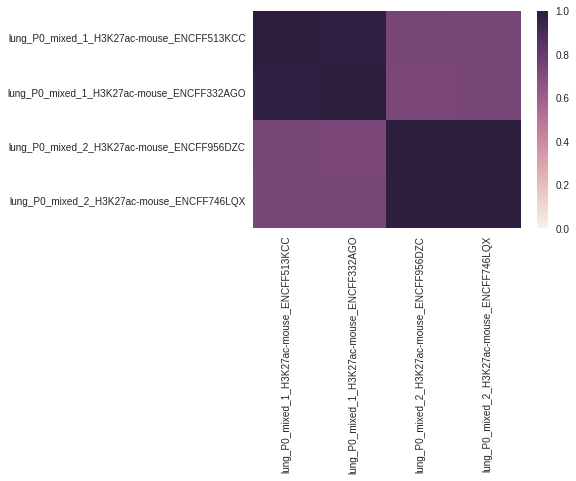

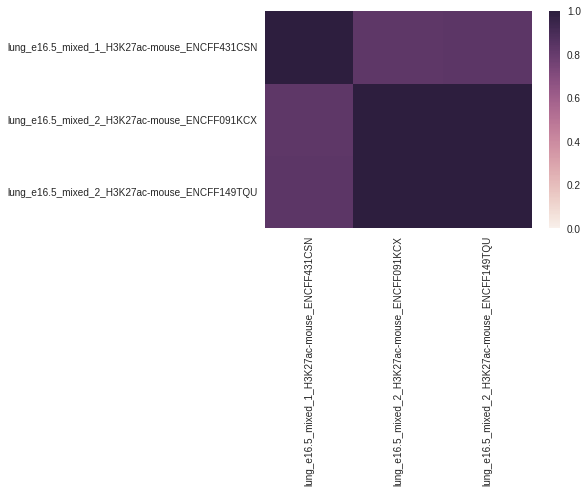

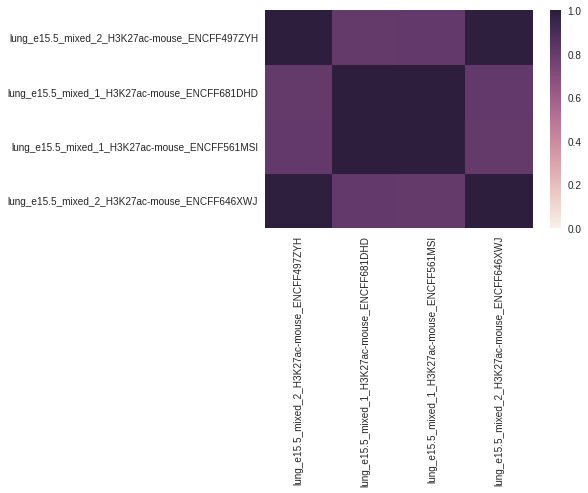

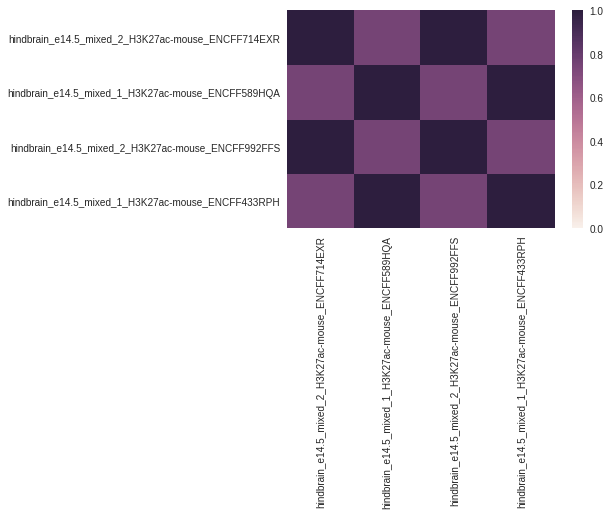

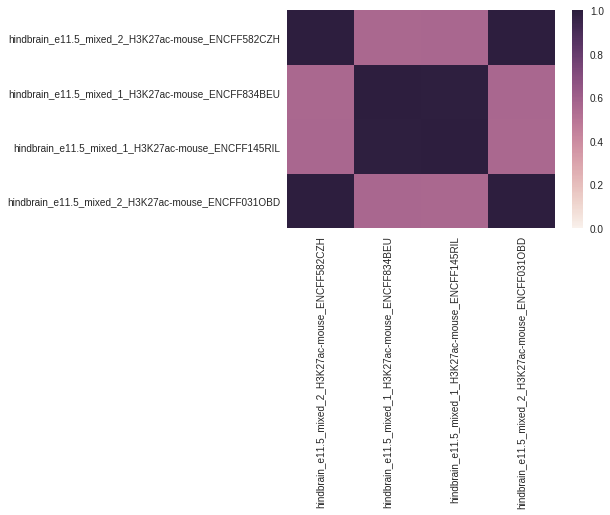

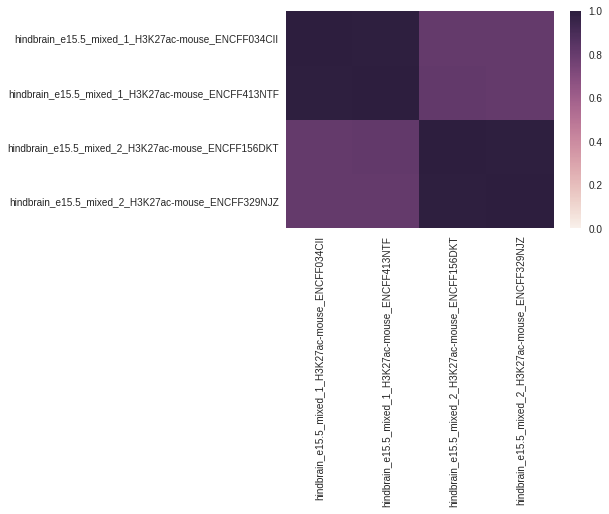

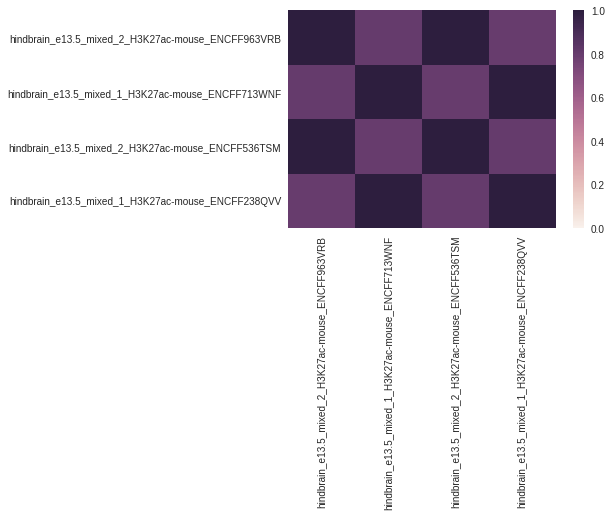

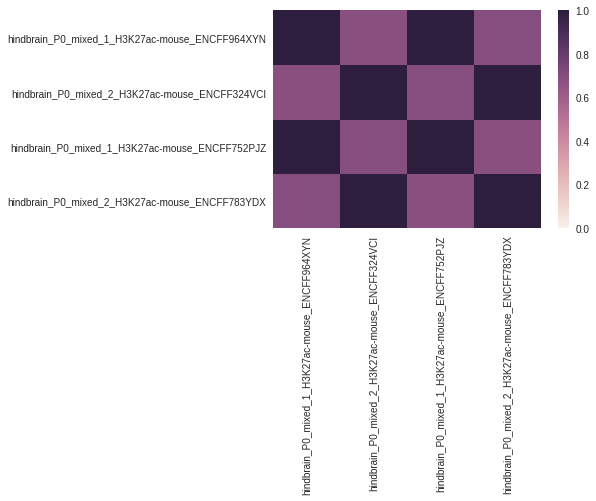

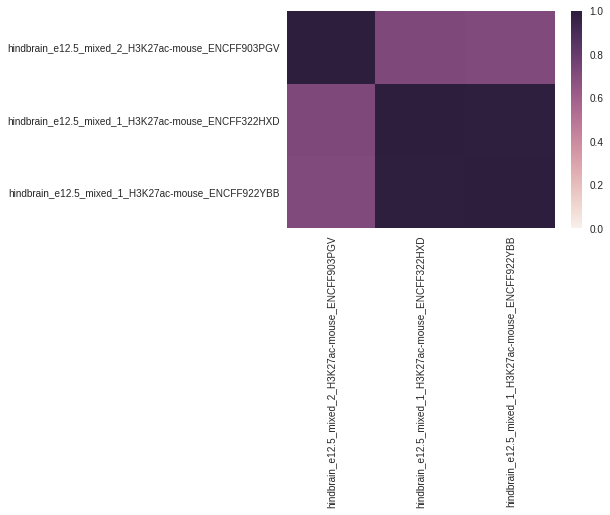

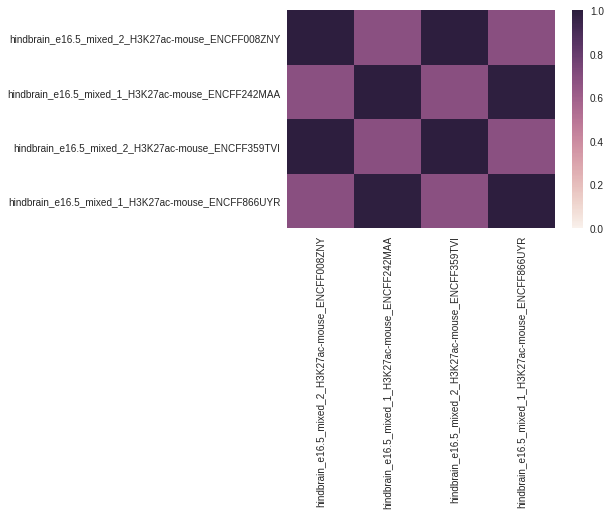

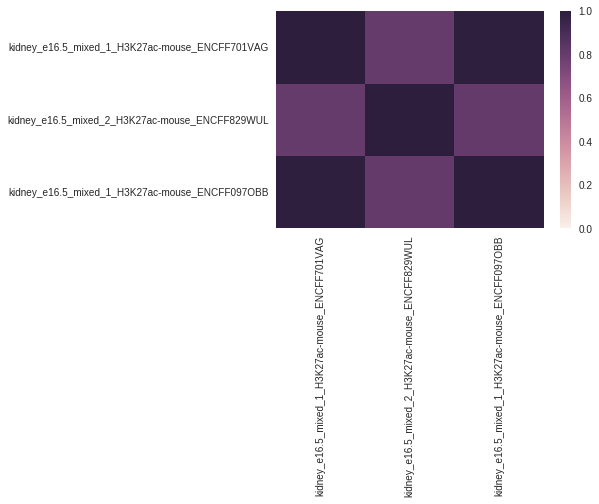

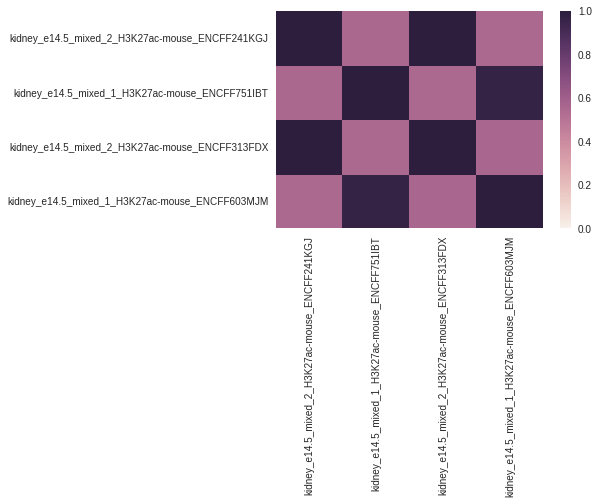

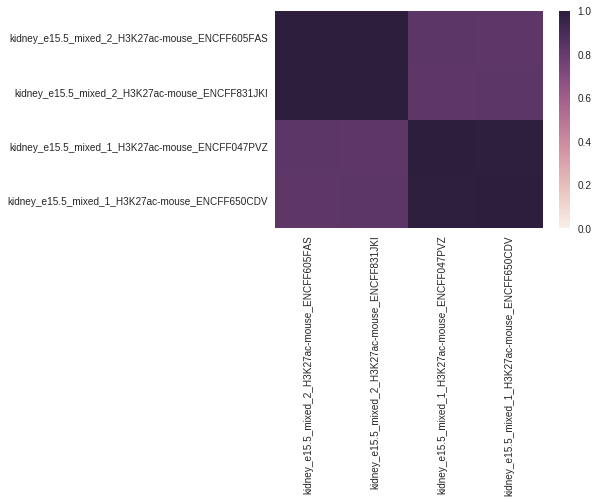

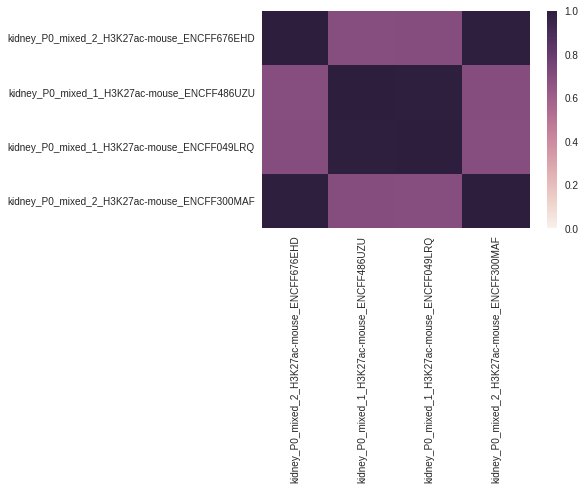

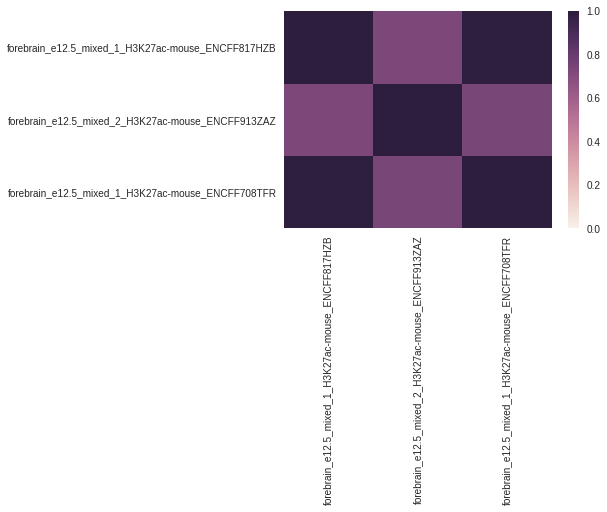

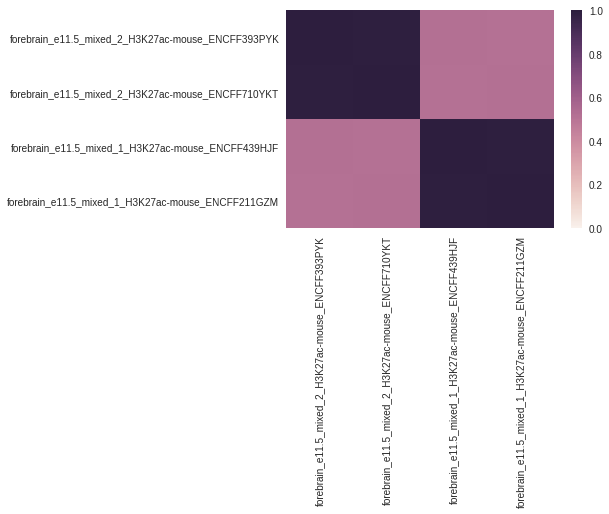

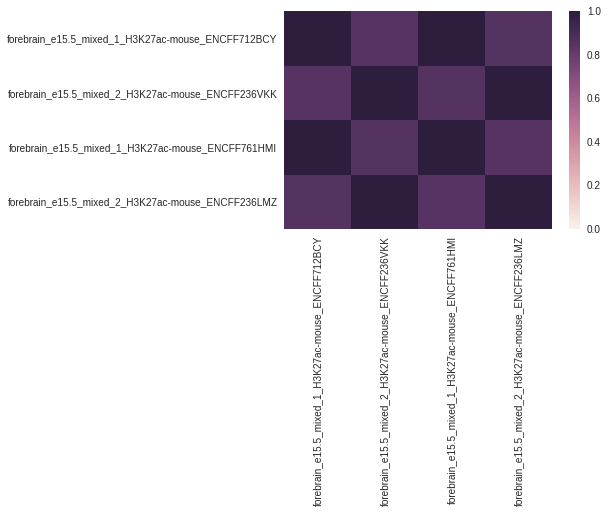

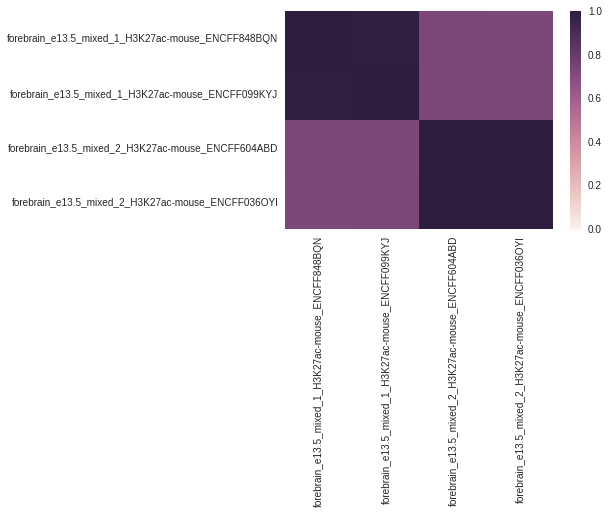

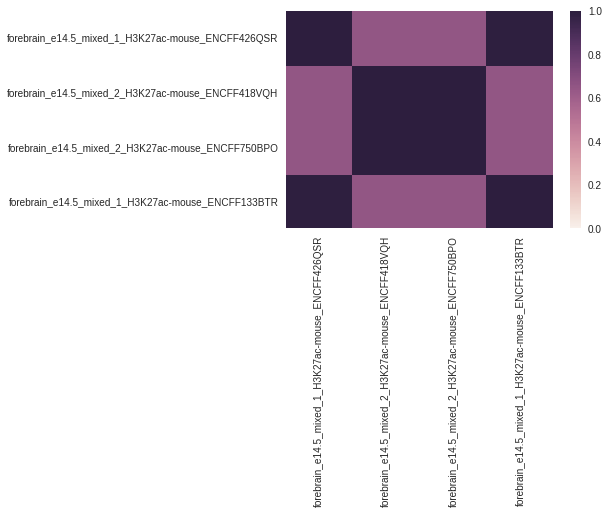

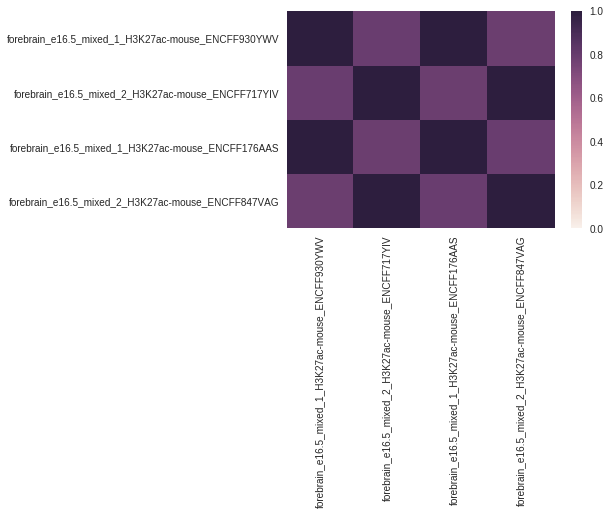

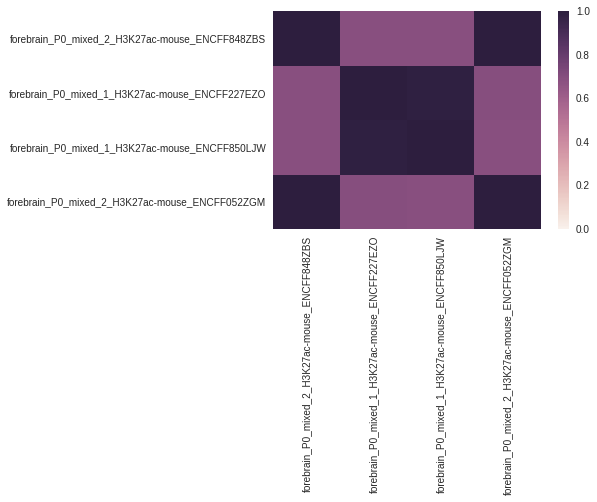

In [65]:
k27ac_to_remove = ['ENCFF001KKQ','ENCFF001KKP','ENCFF001KME','ENCFF001KMD','ENCFF001KGS','ENCFF001KGT']
count = 0
for k in data_analysis.keys():
    for v in data_analysis[k]:
        count += 1
        print(count,k,v)
        plt.figure(count)
        context = enh.ix[:,['{}_{}'.format(k,v) in c for c in enh.columns]]
        context = context.ix[:,[all(sb not in c for sb in k27ac_to_remove) for c in context.columns]]
        sb.heatmap(context.corr(),vmin=0,vmax=1)

## e11.5, e12.5, e13.5, e14.5, e15.5, and e16.5 networks

In [1]:
import pandas as pd
import glob
import numpy as np
import seaborn as sb
import subprocess
import os
import multiprocessing
%matplotlib inline

In [2]:
data_analysis = {'embryonic-facial-prominence': ['e11.5', 'e15.5', 'e12.5', 'e13.5', 'e14.5'],
 'forebrain': ['e12.5', 'e11.5', 'e15.5', 'e13.5', 'e14.5', 'e16.5', 'P0'],
 'heart': ['e11.5', 'e16.5', 'e13.5', 'e15.5', 'P0', 'e12.5', 'e14.5'],
 'hindbrain': ['e14.5', 'e11.5', 'e15.5', 'e13.5', 'P0', 'e12.5', 'e16.5'],
 'intestine': ['P0', 'e15.5', 'e14.5', 'e16.5'],
 'kidney': ['e16.5', 'e14.5', 'e15.5', 'P0'],
 'limb': ['e12.5', 'e13.5', 'e15.5', 'e14.5', 'e11.5'],
 'liver': ['P0', 'e16.5', 'e11.5', 'e15.5', 'e12.5', 'e13.5', 'e14.5'],
 'lung': ['e14.5', 'P0', 'e16.5', 'e15.5'],
 'midbrain': ['e16.5', 'e13.5', 'e14.5', 'e11.5', 'e15.5', 'e12.5', 'P0'],
 'neural-tube': ['e14.5', 'e13.5', 'e11.5', 'e15.5', 'e12.5'],
 'stomach': ['e14.5', 'P0', 'e15.5', 'e16.5']}

In [3]:
exp_pc_df = pd.read_csv('/home/shared/Data/encode/mouse/gene_expression_log2TPM_signal_processed_matrix.txt',sep='\t',index_col=0)
enh = pd.read_csv('/home/shared/Data/encode/mouse/enh_H3K27ac_log2TPM_signal_processed_matrix.txt',sep='\t',index_col=0)

In [4]:
## pariwise pearson correlation coefficient amoung its techincal and biological replicate was < 0.3. Therefore going to remove these samples
rnaseq_to_remove = ['ENCFF662WLV','ENCFF705YYN','ENCFF026IQF','ENCFF892XES','ENCFF668RJN','ENCFF993NNK','ENCFF569ODO','ENCFF863BCB','ENCFF250DXJ','ENCFF434WEQ']
k27ac_to_remove = ['ENCFF001KKQ','ENCFF001KKP','ENCFF001KME','ENCFF001KMD','ENCFF001KGS','ENCFF001KGT']


In [5]:
def get_sample_exp_df(exp_df, tissue, time, excl):
    exp_ft_df = exp_df.ix[:,[all(sb not in c for sb in excl) and (tissue in c) and (time in c) for c in exp_df.columns]]
    mean_exp_ft_df = pd.DataFrame(exp_ft_df.mean(axis=1))
    #print("Expression:", exp_ft_df.shape)
    #print(exp_ft_df.columns)
    return mean_exp_ft_df

def get_sample_k27ac_df(k27ac_df, tissue, time):
    k27ac_ft_df = k27ac_df.ix[:,[(tissue in c) and (time in c) for c in k27ac_df.columns]]
    mean_k27ac_ft_df = pd.DataFrame(k27ac_ft_df.mean(axis=1))
    #print("K27ac:", k27ac_ft_df.shape)
    #print(k27ac_ft_df.columns)
    return mean_k27ac_ft_df

In [6]:
def get_distance_df(gene_df,enh_df):
    enh_pos = []
    for r in enh_df.iterrows():
        pos = "{}:{}-{}".format(r[1][0],r[1][1],r[1][2])
        enh_pos.append(pos)
    gene_names = list(gene_df[3])
    out_d = pd.DataFrame(0,index=enh_pos,columns=gene_names)
    for g in gene_df.iterrows():
        name = g[1][3]
        if g[1][5] == '-':
            g_start = g[1][2]
        else:
            g_start = g[1][1]
        for e in enh_df.iterrows():
            e_pos = "{}:{}-{}".format(e[1][0],e[1][1],e[1][2])
            e_mid = e[1][1]+((e[1][2]-e[1][1])/2)
            d = np.abs(g_start - e_mid)
            out_d.ix[e_pos,name] = int(d)
    return out_d

def get_distance_based_weight(distance):
    ##set weight 0 for distance greater than 500 kb
    distance[distance > 500000] = 1e10000
    dist_weight = 1/np.log2(distance)
    if set(dist_weight.values.flatten()) == {0}:
        wmin = np.sort(list(set(dist_weight.values.flatten())))[0]
        wmax = np.sort(list(set(dist_weight.values.flatten())))[0]
        scaled_dist_weight = dist_weight
    else:
        wmin = np.sort(list(set(dist_weight.values.flatten())))[1]
        wmax = np.sort(list(set(dist_weight.values.flatten())))[-1]
        scaled_dist_weight = (dist_weight-wmin)/(wmax-wmin)
        scaled_dist_weight[scaled_dist_weight<0] = 0
    return(scaled_dist_weight)

In [7]:
def get_enh_gene_weights(tup):
    tad_dir, context_info = tup
    enh_path = '{}/enh.bed'.format(tad_dir)
    gene_path = '{}/gene.bed'.format(tad_dir)
    global mean_gene_exp
    global mean_enh_k27ac
    if os.path.isfile(enh_path) and os.path.isfile(gene_path):
        enh_df = pd.read_csv(enh_path,sep='\t',header=None)
        gene_df = pd.read_csv(gene_path,sep='\t',header=None)
        enh_gene_dist = get_distance_df(gene_df,enh_df)
        scaled_weight = get_distance_based_weight(enh_gene_dist)
        #scaled_weight.to_csv('{}/enh_gene_dist_scaled_weight.txt'.format(tad_dir),sep='\t')
#         m_gene_exp = share_data.g_exp
#         m_enh_k27ac = share_data.e_sig
        tad_gene_exp = mean_gene_exp.ix[scaled_weight.columns,:]
        tad_enh_signal = mean_enh_k27ac.ix[scaled_weight.index,:]
        enh_gene_weight = np.multiply(
            scaled_weight,np.sqrt(np.matmul(tad_enh_signal,tad_gene_exp.T)))
        enh_gene_weight.to_csv('{}/{}_enh_gene_weight.txt'.format(tad_dir,context_info),sep='\t')

In [8]:
def fill_network(d):
    
    enh_path = '{}/enh.bed'.format(d)
    gene_path = '{}/gene.bed'.format(d)
    weight_path = '{}/{}_enh_gene_weight.txt'.format(d,context_info)
    if os.path.isfile(enh_path) and os.path.isfile(gene_path) and os.path.isfile(weight_path):
        weight = pd.read_csv(weight_path,sep='\t',index_col=0)
        weight_dict = weight.to_dict()
#         for c in weight_dict.keys():
#             for r in weight_dict[c].keys():
#                 all_network_dict[c][r] = np.float32(weight_dict[c][r])
    return weight_dict

In [9]:
p = multiprocessing.Pool(64)

tad_dirs = glob.glob('/home/shared/Data/encode/mouse/heart/TADs/TAD_*')
count = 0

hdf = pd.HDFStore('/home/shared/Data/encode/mouse/heart/heart_P0_enh-gene_network.h5',mode='r')
all_weight = hdf['/enh_gene_all_weights']
hdf.close()
out_index = all_weight.index
out_columns = all_weight.columns
del(all_weight)
for tissue in data_analysis.keys():
    for age in data_analysis[tissue]:
        context_info = '{}_{}'.format(tissue,age)
        count += 1
        print(count, context_info)
        if context_info in ['heart_P0','heart_e11.5']:
            next

        mean_gene_exp = get_sample_exp_df(exp_pc_df,age,tissue,rnaseq_to_remove)
        mean_enh_k27ac = get_sample_k27ac_df(enh, age, tissue)
        
#         mgr = multiprocessing.Manager()
#         share_data = mgr.Namespace()
#         share_data.g_exp = mean_gene_exp
#         share_data.e_sig = mean_enh_k27ac
        all_inputs = []
        for d in tad_dirs:
            all_inputs.append((d,context_info))
        
        out = p.map(get_enh_gene_weights,all_inputs)
        
        all_network = pd.DataFrame(0,index=out_index,columns=out_columns).astype(np.float32)
        all_network_dict = all_network.to_dict()
        del(all_network)
    
        out2 = p.map(fill_network,tad_dirs)
        break
    break

1 limb_e12.5


NameError: name 'mean_gene_exp' is not defined

In [ ]:
        all_network = pd.DataFrame(all_network_dict)
        del(all_network_dict)
        all_network.fillna(0,inplace=True)
        
        hdf = pd.HDFStore('/home/shared/Data/encode/mouse/heart/{}_enh-gene_network_F.h5'.format(context_info))
        hdf['/enh_gene_all_weights'] = all_network
        hdf.close()

1 intestine_P0


In [2]:
tad_dirs = glob.glob('/home/shared/Data/encode/mouse/heart/TADs/TAD_*')
count = 0

hdf = pd.HDFStore('/home/shared/Data/encode/mouse/heart/heart_P0_enh-gene_network.h5',mode='r')
all_weight = hdf['/enh_gene_all_weights']
hdf.close()
out_index = all_weight.index
out_columns = all_weight.columns
del(all_weight)

In [5]:
p = multiprocessing.Pool(30)

In [35]:
def fill_network(d):
    context_info = 'heart_P0'
    enh_path = '{}/enh.bed'.format(d)
    gene_path = '{}/gene.bed'.format(d)
    weight_path = '{}/{}_enh_gene_weight.txt'.format(d,context_info)
    if os.path.isfile(enh_path) and os.path.isfile(gene_path) and os.path.isfile(weight_path):
        weight = pd.read_csv(weight_path,sep='\t',index_col=0)
        #weight_dict = weight.to_dict()
#         for c in weight_dict.keys():
#             for r in weight_dict[c].keys():
#                 all_network_dict[c][r] = np.float32(weight_dict[c][r])
        return weight

In [4]:
context_info = 'heart_P0'

In [6]:
out2 = p.map(fill_network,tad_dirs[:10])

In [7]:
len(out2)

10

In [10]:
np_array_list = []
for df in out2:
    np_array_list.append(df.as_matrix())

comb_np_array = np.hstack(np_array_list)



ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [36]:
fill_network(tad_dirs[0])

,Gpx3,Anxa6,P4ha2,Il3,Csf2,Hint1,Lyrm7,4930404A10Rik,Acsl6,Slc22a4,Pdlim4,Tnip1,Fnip1,Rapgef6,Cdc42se2,Slc22a21
chr11:53908719-53909689,0.000000,0.000000,0.339415,0.0,0.0,0.000000,0.000000,0.0,0.016342,0.210059,0.333925,0.000000,0.000000,0.000000,0.000000,0.322660
chr11:53928842-53929312,0.000000,0.000000,0.417961,0.0,0.0,0.000000,0.000000,0.0,0.021909,0.263477,0.412876,0.000000,0.000000,0.000000,0.000000,0.425224
chr11:53930776-53931520,0.000000,0.000000,0.502872,0.0,0.0,0.000000,0.000000,0.0,0.026551,0.317798,0.497050,0.000000,0.000000,0.000000,0.000000,0.516468
chr11:53987938-53988970,0.000000,0.000000,0.647034,0.0,0.0,0.000000,0.000000,0.0,0.037965,0.478779,0.663363,0.000000,0.034478,0.000000,0.000000,0.989942
chr11:53991456-53992480,0.000000,0.000000,0.673185,0.0,0.0,0.000000,0.000000,0.0,0.039542,0.508658,0.693099,0.000000,0.037668,0.000000,0.000000,0.882621
chr11:53992554-53993508,0.000000,0.000000,0.616942,0.0,0.0,0.000000,0.000000,0.0,0.036246,0.469373,0.636051,0.000000,0.035002,0.000000,0.000000,0.777077
chr11:54002301-54009287,0.000000,0.000000,0.727588,0.0,0.0,0.000000,0.000000,0.0,0.042653,0.618741,0.764861,0.000000,0.047361,0.000000,0.000000,0.632194
chr11:54020273-54021080,0.000000,0.000000,0.700664,0.0,0.0,0.000000,0.000000,0.0,0.040483,0.809577,0.761655,0.000000,0.050762,0.000000,0.000000,0.439638
chr11:54055827-54065085,0.000000,0.000000,1.386974,0.0,0.0,0.000000,0.000000,0.0,0.069976,0.608665,2.129923,0.000000,0.107507,0.027854,0.000000,0.404862
chr11:54071726-54073596,0.000000,0.000000,1.692978,0.0,0.0,0.000000,0.000000,0.0,0.077462,0.536424,2.926459,0.000000,0.123922,0.038678,0.000000,0.379472


In [20]:
%%time
df = pd.concat(map(fill_network,tad_dirs))

CPU times: user 9min 37s, sys: 7.92 s, total: 9min 45s
Wall time: 9min 43s


In [23]:
df.fillna(0,inplace=True)

In [24]:
df

,0610007P14Rik,0610009B22Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610011F06Rik,0610030E20Rik,0610037L13Rik,1110001J03Rik,...,Zswim8,Zw10,Zwilch,Zxdc,Zyg11a,Zyg11b,Zyx,Zzef1,Zzz3,a
chr11:53908719-53909689,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr11:53928842-53929312,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr11:53930776-53931520,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr11:53987938-53988970,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr11:53991456-53992480,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr11:53992554-53993508,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr11:54002301-54009287,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr11:54020273-54021080,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr11:54055827-54065085,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr11:54071726-54073596,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
import networkx as nx

In [16]:
out2[0]

{'4930404A10Rik': {'chr11:53908719-53909689': 0.0,
  'chr11:53928842-53929312': 0.0,
  'chr11:53930776-53931520': 0.0,
  'chr11:53987938-53988970': 0.0,
  'chr11:53991456-53992480': 0.0,
  'chr11:53992554-53993508': 0.0,
  'chr11:54002301-54009287': 0.0,
  'chr11:54020273-54021080': 0.0,
  'chr11:54055827-54065085': 0.0,
  'chr11:54071726-54073596': 0.0,
  'chr11:54088519-54088906': 0.0,
  'chr11:54089185-54089543': 0.0,
  'chr11:54106250-54107650': 0.0,
  'chr11:54108086-54109810': 0.0,
  'chr11:54111169-54114917': 0.0,
  'chr11:54115198-54115720': 0.0,
  'chr11:54115795-54116912': 0.0,
  'chr11:54121682-54123374': 0.0,
  'chr11:54126039-54128105': 0.0,
  'chr11:54149478-54150937': 0.0,
  'chr11:54155503-54156052': 0.0,
  'chr11:54156279-54157270': 0.0,
  'chr11:54174493-54175117': 0.0,
  'chr11:54175144-54175719': 0.0,
  'chr11:54195873-54196757': 0.0,
  'chr11:54203141-54203543': 0.0,
  'chr11:54256541-54257697': 0.0,
  'chr11:54310892-54311262': 0.0,
  'chr11:54311286-54315595': 0.

In [15]:
nx.to_pandas_dataframe(g)

,Fnip1,Slc22a21,Csf2,chr11:55019961-55030091,P4ha2,chr11:54149478-54150937,Pdlim4,chr11:54463888-54465640,chr11:54195873-54196757,Lyrm7,...,chr11:54717607-54719674,chr11:54126039-54128105,chr11:54539533-54541637,chr11:54919188-54922492,chr11:54111169-54114917,chr11:54935042-54938714,chr11:54115198-54115720,chr11:54203141-54203543,chr11:54951636-54953375,4930404A10Rik
Fnip1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
Slc22a21,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
Csf2,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
chr11:55019961-55030091,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
P4ha2,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
chr11:54149478-54150937,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
Pdlim4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
chr11:54463888-54465640,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
chr11:54195873-54196757,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
Lyrm7,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [20]:
out2[1].shape

(44, 8)

In [21]:
len(out2)

1679

In [ ]:
all_network = pd.DataFrame(0,index=out_index,columns=out_columns).astype(np.float32)
all_network_dict = all_network.to_dict()
for d in out2:
    if d == None:
        next
    for c in d.keys():
        for r in d[c].keys():
            all_network_dict[c][r] = np.float32(d[c][r])

In [29]:
all_network = pd.DataFrame(all_network_dict)
all_network.shape

KeyboardInterrupt: 

### Evaluating heart P0 and E11.5 Enh-gene

In [6]:
import pandas as pd
hdf = pd.HDFStore('/home/shared/Data/encode/mouse/heart/heart_e11.5_enh-gene_network.h5')

In [7]:
network = hdf['/enh_gene_all_weights']

In [8]:
hdf.close()

In [9]:
hdf = pd.HDFStore('/home/shared/Data/encode/mouse/heart/heart_P0_enh-gene_network.h5')
network0 = hdf['/enh_gene_all_weights']

In [11]:
network0_sort = network0.ix[:,network.columns]

In [12]:
import numpy as np
np.all(network0_sort.index == network.index)

True

In [13]:
delta_2_1 = network0_sort - network


In [21]:
import seaborn as sb
%matplotlib inline

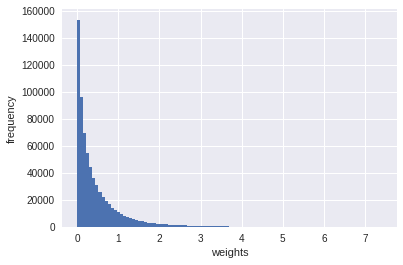

In [24]:
vals = network.values.flatten()
vals_flt = vals[vals>0]
delta = delta_2_1.values.flatten()
vals_delta = delta
sb.plt.hist(vals_flt,bins=100)
sb.plt.xlabel('weights')
sb.plt.ylabel('frequency')

In [14]:
delta_genes_score = delta_2_1.sum()

In [26]:
g_n = list(delta_genes_score.sort_values(0,ascending=False).index[:200])

In [28]:
e11_specific.shape

(113381, 16385)

In [3]:
import gseapy as gp

In [27]:
g_n

['Slc25a34',
 'Fabp4',
 'Ntn4',
 'Hist1h4f',
 'Dpt',
 'Aspn',
 'Fhl2',
 'Hist1h3f',
 'Irf2bp2',
 'Sema7a',
 'Zbtb16',
 'Hist2h2ab',
 'March3',
 'Sash1',
 'Hist1h4h',
 'Chrna9',
 'Hist1h2bh',
 'Aqp7',
 'Cd300lg',
 'Timp4',
 'Slc10a6',
 'Hist1h2bg',
 'Hist1h2ad',
 'Adrb1',
 'Upk3a',
 'Zfp366',
 'Clec2d',
 'Aqp1',
 'Fam46b',
 'Aatk',
 'Lbh',
 'Hist1h2bf',
 'Kcnb1',
 'Higd1b',
 'Phospho1',
 'Myom2',
 'Sost',
 'Hist1h2af',
 'Hist2h3c2',
 'Kcng2',
 'Neurl1b',
 'Papln',
 'Jdp2',
 'Ly6a',
 'Ninj2',
 'Kcnip2',
 'Mb',
 'Tpsb2',
 'Mpst',
 'Atp8b1',
 'Aoc3',
 'Ckm',
 'Hist1h3e',
 'Sgcg',
 'Tnfsf10',
 'Pdgfb',
 'Hist2h2ac',
 'Col15a1',
 'Scgb1a1',
 '1700086D15Rik',
 'Ssu2',
 'Cp',
 'Dpep1',
 'Hist1h1d',
 'Hist2h2aa2',
 'Ltbp2',
 'Lgals3bp',
 'Hist1h3g',
 'Asprv1',
 'Casq2',
 'Adra1b',
 '6330403A02Rik',
 'Abca8a',
 'Ndrg1',
 'Pdzrn3',
 'Cadm4',
 'Gfod1',
 'Ntn1',
 'Ly6c1',
 'Lynx1',
 'Hist1h2be',
 'Adcy9',
 'Gpihbp1',
 '4933440N22Rik',
 'Tnxb',
 'Adck3',
 'Hist2h4',
 'Pck1',
 'Ablim3',
 'Mgll',
 'Kc

In [15]:
genes_bed = pd.read_csv('/home/shared/Data/gencode/mouse/M4/protein_coding_filtered.gtf',sep='\t',header=None)

In [21]:
r

(21992, 0                                                 chr3
 1                                               HAVANA
 2                                                 gene
 3                                             88242874
 4                                             88254709
 5                                                    .
 6                                                    -
 7                                                    .
 8    gene_id "ENSMUSG00000104445.1"; transcript_id ...
 Name: 21992, dtype: object)

In [28]:
tup = []
for r in genes_bed.iterrows():
    if np.any([g in r[1][8] for g in g_n]):
        if r[1][6] == '-':
            tup.append((r[1][0],r[1][4]-750,r[1][4]+750))
        else:
            tup.append((r[1][0],r[1][3]-750,r[1][3]+750))

In [29]:
pd.DataFrame(tup).to_csv("/home/vamin/projects/epee/bedfiles/top200_e11.5_genes.bed",sep='\t',header=None,index=None)

In [47]:
enr = gp.enrichr(gene_list=g_n,description="Top20_active_in_e11.5_heart", gene_sets="KEGG_2016", outdir='enrichr_kegg', cutoff=0.5)

2017-08-16 15:45:09,394 Connecting to Enrichr Server to get latest library names
2017-08-16 15:45:09,394 Connecting to Enrichr Server to get latest library names
2017-08-16 15:45:09,394 Connecting to Enrichr Server to get latest library names


URLError: <urlopen error [SSL: UNKNOWN_PROTOCOL] unknown protocol (_ssl.c:600)>

In [4]:
gp.__version__

'0.7.4'

In [5]:
names = gp.get_library_name()

URLError: <urlopen error [SSL: UNKNOWN_PROTOCOL] unknown protocol (_ssl.c:600)>

In [9]:
import pandas as pd
import numpy as np

In [36]:
peaks = pd.read_csv('/home/shared/Data/encode/mouse/enhancer/peak_overlapped_pc_tss_subtracted_enh_mouse_pc_tss_subtracted_sorted_centered_merged.bed',sep='\t',header=None)

In [32]:
def get_peaks_centered(df,n=500):
    df[1] = (df[1] + ((df[2]-df[1])/2).astype(int))-int(n/2)
    df[2] = df[1]+int(n)
    return df

In [37]:
peaks_centered = get_peaks_centered(peaks)

In [38]:
peaks_centered.to_csv('/home/shared/Data/encode/mouse/enhancer/peak_overlapped_pc_tss_subtracted_enh_mouse_pc_tss_subtracted_sorted_centered_merged_center.bed',sep='\t',header=None,columns=None,index=None)

In [34]:
peaks_centered[2]-peaks_centered[1]

0         500
1         500
2         500
3         500
4         500
5         500
6         500
7         500
8         500
9         500
10        500
11        500
12        500
13        500
14        500
15        500
16        500
17        500
18        500
19        500
20        500
21        500
22        500
23        500
24        500
25        500
26        500
27        500
28        500
29        500
         ... 
131453    500
131454    500
131455    500
131456    500
131457    500
131458    500
131459    500
131460    500
131461    500
131462    500
131463    500
131464    500
131465    500
131466    500
131467    500
131468    500
131469    500
131470    500
131471    500
131472    500
131473    500
131474    500
131475    500
131476    500
131477    500
131478    500
131479    500
131480    500
131481    500
131482    500
dtype: int64

In [40]:
pd.DataFrame({'a': [1,2,3], 'b': [4,5,2]})

,a,b
0,1,4
1,2,5
2,3,2


In [44]:
import numpy as np
def getBackgroundPeaks(fragmentPeaks,bias,niterations=50,w=0.1,bs=50):
    fragments_per_peak = fragmentPeaks
    intensity = np.log10(fragments_per_peak)
    norm_mat = pd.DataFrame({'intensity': intensity, 'bias': bias})
    
    return norm_mat
    
    

In [50]:
df = getBackgroundPeaks([3,7,2,1],[0.3,0.2,0.1,0.4])

In [55]:
chol_cov_mat = np.linalg.cholesky(df.cov())

In [59]:
np.tril_indices(chol_cov_mat.T, df.T)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()